# Class 04: Communities Revisited and Models of Community

Goal of today's class:
1. Revisit community structure
2. Revisit modularity as a measure
3. Highlight shortcomings of modularity

__________


1. Come in. Sit down. Open Teams.
2. Find your notebook in your /Class_04/ folder.
________

In [1]:
import networkx as nx
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rc
rc('axes', fc='w')
rc('figure', fc='w')
rc('savefig', fc='w')
rc('axes', axisbelow=True)

**Where we are in the course:** Last week we used Bayes' rule + latent variables as a framework for thinking about network inference. Today we'll pose a similar question to lay the groundwork for thinking about community detection as an inference problem --- and to see why purely optimizing modularity has limits.

## Bridge: Bayes → communities

Last week we kept writing some version of:

$$
P(\theta \mid \text{data}) \propto P(\text{data} \mid \theta)\, P(\theta)
$$

For community detection, the unknown thing is often *a discrete label per node*:

- $z_i \in \{1,2,\dots,B\}$ is the (latent) community assignment of node $i$
- $A$ is the observed adjacency matrix (or edge list)

A **model-based** community question looks like:

$$
P(\mathbf{z} \mid A) \propto P(A \mid \mathbf{z})\, P(\mathbf{z})
$$

and then we choose a goal (e.g.):
- MAP estimate: find $\hat{\mathbf{z}} = \arg\max_{\mathbf{z}} P(\mathbf{z} \mid A)$  
- Posterior sampling: explore many plausible $\mathbf{z}$’s and quantify uncertainty


An **algorithmic** community question often looks like:
- "Define a score for a partition, then maximize it" (e.g., modularity), or  
- "Define a procedure that 'breaks' the graph into groups" (e.g., edge-betweenness removal)
________


### Today
Many popular "algorithmic" methods are secretly making assumptions about a null model and about what counts as good structure.

## Community Detection in Networks

Community detection is one of the most important tasks in network science and graph theory, focusing on identifying groups of nodes that are more densely connected to each other than to the rest of the network. These groups, often referred to as **communities**, **modules**, **clusters**, **blocks** are essential for understanding the structure and function of complex systems represented as graphs, such as social networks, biological systems, and information networks.

---


### What is a Community?

A community in a network can be intuitively understood as a subset of nodes where connections (edges) between members of the community are more frequent or stronger than connections to the rest of the network. In mathematical terms, a graph $ G = (V, E) $, where $ V $ represents the set of nodes and $ E $ represents the set of edges, can be partitioned into communities $ C_1, C_2, \dots, C_k $ such that:

$$
\sum_{i=1}^{k} \left( \text{Intra-community edges in } C_i \right) \gg \text{Inter-community edges between } C_i \text{ and other communities}.
$$

This means that each community $ C_i $ has a higher density of internal connections compared to its connections to other communities in the network. A community is generally defined as a subset of nodes that are densely connected internally, but sparsely connected to nodes outside the community. In other words, members of a community have many intra-community edges but relatively few inter-community edges.*


\***Note:** This is not always the strongest definition! We'll see more of this next week.

#### Mathematically:
For a given community $ C \subseteq V $, the internal density of edges is much higher than the external density --- $ \frac{\text{Intra-community edges in } C}{|C|} $ --- should be maximized, while the number of inter-community edges should be minimized. The goal of *community detection* per se is to partition the nodes of the network into communities $ C_1, C_2, \dots, C_k $ such that the intra-community connections are maximized and inter-community connections are minimized.



In practice, community detection helps in revealing the underlying structure of the network and offers insights into the network's functional modules, social groups, or thematic clusters.

_______
Communities can be defined in several ways, each based on different structural properties:

#### a. Clique:
A **clique** is the most restrictive form of a community, where every node is connected to every other node in the community. In a graph, a clique of size $ k $ is a subgraph $ K_k $ where every pair of nodes has an edge: $ \forall v_i, v_j \in C : (v_i, v_j) \in E $. However, real-world networks rarely exhibit perfect cliques.

#### b. Dense Subgraph:
A less restrictive notion than cliques, a dense subgraph satisfies a high ratio of existing edges to potential edges. The density $ d(C) $ of a community $ C $ is defined as: $ d(C) = \frac{|E_C|}{|C|(|C| - 1) / 2} $, where $ E_C $ represents the number of edges within community $ C $. A high density indicates a tightly-knit group.

#### c. Conductance:
The **conductance** of a community $ C $ measures the fraction of total edge volume that points outside the community: $ \Phi(C) = \frac{\sum_{i \in C, j \notin C} A_{ij}}{\min(\text{vol}(C), \text{vol}(V \setminus C))} $, where $ \text{vol}(C) $ is the sum of degrees of nodes in $ C $. Low conductance implies strong community structure.


### Applications of Community Detection

Community detection has wide-ranging applications across various disciplines:

- Social Networks: Communities often correspond to real-world groups such as families, friends, or professional associations.
- Biological Networks: In protein-protein interaction networks, communities may represent functional modules of proteins working together.
- Information Networks: In citation networks, communities may represent topics or research areas.
- Infrastructure: In power grids or transportation networks, communities can indicate regions or hubs that are densely interconnected.

By identifying communities, one can gain insights into the **organization**, **function**, and **dynamics** of complex systems.

---

In [2]:
# we actually have some notion of "ground truth" in the karate club...
K = nx.karate_club_graph()
pos = nx.spring_layout(K)

club_color = {
    'Mr. Hi': 'teal',
    'Officer': 'limegreen',
}
node_colors = [club_color[K.nodes[n]['club']] for n in K.nodes]

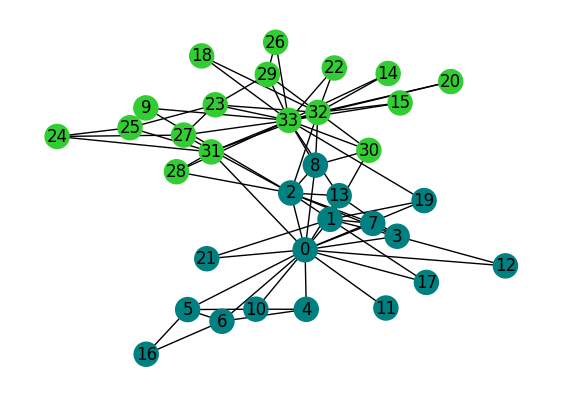

In [3]:
fig, ax = plt.subplots(1,1,figsize=(7,5),dpi=100)

nx.draw(K, pos, node_color=node_colors, with_labels=True,ax=ax)

plt.show()

____________
### The Original Karate Club Viz
![](images/karate_og.png)

## Exercise to start class

Partitions can be represented many different ways. Create at least three ways to represent the `karate_club` (ground truth) partition as a data object.

**3 minutes**

In [4]:
pass

____________

We’ll represent a **partition** either as:

- `communities = [set(...), set(...), ...]` (a list of node-sets), or
- `labels = {node: community_id}` (a dict mapping node → group).

We’ll convert between them as needed.

In [5]:
def communities_to_labels(comms):
    """
    Convert a partition (list of node sets) into a node→community-id map.

    Parameters
    ----------
    comms : list[set]
        Communities represented as node sets. For most of this notebook we assume
        `comms` is a *partition* (disjoint, covers all nodes), but this helper
        will still produce a mapping for any list of sets.

    Returns
    -------
    labels : dict
        Mapping from node to an integer community id (0,1,2,...).
    """
    labels = {}
    for cid, c in enumerate(comms):
        for v in c:
            labels[v] = cid

    return labels


def labels_to_communities(labels):
    """
    Inverse of :func:`communities_to_labels`.

    Parameters
    ----------
    labels : dict
        Node -> community id.

    Returns
    -------
    comms : list[set]
        Communities as a list of node sets, ordered by community id.
    """

    out = {}
    for v, cid in labels.items():
        out.setdefault(cid, set()).add(v)

    return [out[cid] for cid in sorted(out)]

In [6]:
# Other helper functions:

def draw_partition(G, comms, pos=None, ax=None, title=None, color_map=None,
                   fig_size=(4,4), dpi_plot=120):
    """
    Draw a graph with nodes colored by community membership.

    This is intentionally lightweight (good enough for class).

    Parameters
    ----------
    G : nx.Graph
        Graph to draw.
    comms : list[set]
        Communities as node sets.
    pos : dict or None
        Node -> (x,y) layout. If None, uses a seeded spring layout.
    ax : matplotlib axis or None
        Axis to draw on. If None, creates a new figure+axis.
    title : str or None
        Optional plot title.

    Returns
    -------
    ax : matplotlib axis
    pos : dict
        Node positions used for drawing.
    """

    if pos is None:
        pos = nx.spring_layout(G, seed=1)
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=fig_size,dpi=dpi_plot)

    labels = communities_to_labels(comms)
    node_colors = [labels.get(v, -1) for v in G.nodes()]
    # -1 for "unassigned" (shouldn't happen for partitions)

    nx.draw_networkx_nodes(G, pos, node_color=node_colors,
                           cmap=color_map, node_size=80, ax=ax,
                           linewidths=0.5, edgecolors="white")
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.45, width=1.0)
    ax.set_axis_off()
    if title:
        ax.set_title(title)
    return ax, pos


from networkx.algorithms import community
from networkx.algorithms.community.quality import modularity as nx_modularity
def safe_modularity(G, comms, weight=None, resolution=1.0):
    """
    Compute modularity using NetworkX (configuration-model null).

    Parameters
    ----------
    G : nx.Graph or nx.DiGraph
        Graph (undirected or directed). NetworkX implements both variants.
    comms : list[set]
        Communities as node sets (should be a partition for standard modularity).
    weight : str or None
        Edge attribute name to use as weights. If None, treats all edges as weight 1.
    resolution : float
        Resolution parameter γ. γ>1 biases toward smaller groups; γ<1 toward larger.

    Returns
    -------
    Q : float
        Modularity value.
    """

    return nx_modularity(G, comms, weight=weight, resolution=resolution)

## Without ground truth labels, how do we algorithmically detect communities in network data?

In [7]:
pass

_________
## Modularity

One of the most widely used metrics for evaluating the quality of a community structure is **modularity**, proposed by Newman and Girvan (2004). Modularity purports to measure the difference between the actual number of intra-community edges and the expected number of such edges in a random graph with the same degree distribution. The modularity, $Q$, of a given partition $C$ of our adjacency matrix $A$ is:

$$Q (A,C) = \frac{1}{2M} \sum_{i,j} \left( A_{ij} - \frac{k_i k_j}{2M} \right) \delta (C_i,C_j) $$

Where:
- $ A_{ij} $ is the element of the adjacency matrix (1 if there is an edge between nodes $i$ and $j$, 0 otherwise).
- $ k_i $ and $ k_j $ are the degrees of nodes $i$ and $j$, respectively.
- $ M $ is the total number of edges in the network.
- $ \delta(C_i, C_j) $ is a Kronecker delta, equal to 1 if nodes $i$ and $j$ are in the same community, and 0 otherwise.


Modularity values range from $-1$ to $1$, with higher values indicating stronger community structure. According to some in the early literature of modularity, values of $ Q \approx 0.3 $ or higher can signifie a significant division into communities.\*

\* **Note**: Today, there are strong and damning critiques of modularity as a measure. We are introducing it here as a historical exercise and as a way to motivate next class's theme: *inferential approaches to community detection*.

________
### Coding Modularity

What are the key steps we'll need to do in order to implement this?

In [8]:
def calculate_modularity(G, partition):
    """
    Calculates the modularity score for a given partition of
    the graph, whether the graph is weighted or unweighted.
    
    Modularity is a measure of the strength of division of a
    network into communities. It compares the actual 
    density of edges within communities to the expected density
    if edges were distributed randomly. For weighted 
    graphs, the weight of the edges is taken into account.

    The modularity Q is calculated as:
    
    Q = (1 / 2m) * sum((A_ij - (k_i * k_j) / (2m)) * delta(c_i, c_j))

    where:
    - A_ij is the weight of the edge between nodes i and j (1 if unweighted).
    - k_i is the degree of node i (or the weighted degree for weighted graphs).
    - m is the total number of edges in the graph, or the total weight of
          the edges if the graph is weighted.
    - delta(c_i, c_j) is 1 if nodes i and j belong to the same community,
          and 0 otherwise.

    Parameters:
    -----------
    G : networkx.Graph
        The input graph, which can be undirected and either weighted or
        unweighted. The graph's nodes represent the entities, and its edges
        represent connections between them.
    
    partition : list of sets
        A list of sets where each set represents a community. Each set
        contains the nodes belonging to that community. For example,
        [{0, 1, 2}, {3, 4}] represents two communities, one with nodes 0,
        1, and 2, and another with nodes 3 and 4.
    
    Returns:
    --------
    modularity_score : float
        The modularity score for the given partition of the graph. A higher
        score indicates stronger (assortative) community structure, and a
        lower (or negative) score suggests weak or no community structure.

    Notes:
    ------
    - If the graph has weights, they will be used in the modularity calculation.
      If no weights are present, the function assumes each edge has a weight of
      1 (i.e., unweighted).
    
    - The function assumes that all nodes in the graph are assigned to exactly
      one community. If any node is missing from the community list, it is
      treated as not belonging to any community, and the results may not be accurate.
    
    - If the graph has no edges, the modularity is undefined, and this function
      will return 0 because the total number of edges (2m) would be zero.
    
    Example:
    --------
    >>> import networkx as nx
    >>> G = nx.karate_club_graph()
    >>> communities = [{0, 1, 2, 3, 4}, {5, 6, 7, 8, 9, 10}]
    >>> modularity_score = calculate_modularity(G, communities)
    >>> print("Modularity:", modularity_score)
    
    References:
    -----------
    Newman, M. E. J., & Girvan, M. (2004). Finding and evaluating community structure 
    in networks. Physical Review E, 69(2), 026113.
    """
    

    pass


Modularity asks: "Are there **more edges inside groups** than we would expect *by chance*?"

### The hidden assumption: the null model

The term $\frac{k_i k_j}{2m}$ is the expected number of edges between $i$ and $j$ in the **configuration model** (a random graph with the same degree sequence, in expectation).

So modularity is basically:

$$
Q \propto \text{(observed within-group edges)} - \text{(expected within-group edges under the null)}
$$

That "expected under the null" is why modularity can be powerful — and why it can be misleading when the null is a poor baseline for your data.

### Why is the expected term $\frac{k_i k_j}{2m}$?

- Imagine each node $i$ has $k_i$ "stubs" (half-edges).
- There are $2m$ total stubs in the network.
- If we randomly pair stubs to form edges, the probability that a stub from $i$ connects to a stub from $j$ is roughly proportional to $k_j/(2m)$.
- Node $i$ has $k_i$ stubs, so the expected number of $i\!\leftrightarrow\!j$ connections scales like:

$$
\mathbb{E}[A_{ij}] \approx k_i \frac{k_j}{2m} = \frac{k_i k_j}{2m}.
$$


Note: This is *approximate* (because the configuration model allows multi-edges/self-loops in the simplest form), but it captures the baseline modularity is comparing against.

_________
#### And many... many... many more...
![](images/karate_fig.png)

Common flavors of community detection:

- **Assortative / "dense inside, sparse outside"**  
  The classic social-network intuition. Many algorithms optimize for this.

- **Disassortative / "roles" or "types"**  
  Bipartite-ish structure, core–periphery, hierarchy, etc.  
  (SBMs handle these naturally; modularity often struggles.)

- **Overlapping**  
  Nodes can belong to multiple groups (e.g., people in multiple social circles).

- **Hierarchical / multiscale**  
  Groups inside groups (e.g., department → lab → project team).

In [9]:
from collections import defaultdict
from collections.abc import Iterable, Mapping, Sequence

def calculate_modularity(G, partition, weight=None,
                         resolution=1.0, partition_format=None, nodes=None,
                         validate=True, return_details=False):
    """
    Compute Newman–Girvan modularity for a partition of a graph.

    This function is intentionally verbose and pedagogical.

    -----------------------------
    What modularity is measuring
    -----------------------------
    Modularity compares:

      (1) the actual total weight of edges *inside* each community

    to

      (2) the expected total weight inside each community under a null model
          where edges are placed at random BUT node degrees are preserved in expectation
          (the configuration model).

    The "classic" (undirected) definition is:

      Q = (1 / 2m) * sum_{i,j} [ A_ij - γ * (k_i k_j)/(2m) ] * 1[c_i = c_j]

    where:
      - A_ij is the (weighted) adjacency matrix entry.
      - k_i is (weighted) degree of node i.
      - m is total edge weight (so 2m = sum_i k_i).
      - γ is the resolution parameter (γ=1 is standard).
      - 1[c_i = c_j] is 1 if i and j are in the same community else 0.

    A key algebraic simplification (Clauset-Newman-Moore 2004) gives:

      Undirected:
        Q = Σ_c [ L_c / m  -  γ * (k_c / (2m))^2 ]

      Directed (Leicht-Newman):
        Q = Σ_c [ L_c / m  -  γ * (k_out,c * k_in,c) / m^2 ]

    where:
      - L_c is total internal edge weight within community c (counting each edge once).
      - k_c is sum of degrees in community c.
      - k_out,c and k_in,c are sums of out- and in-degrees in community c.

    -----------------------------
    Partition formats accepted
    -----------------------------
    By default the function tries to infer the partition format, but for teaching
    it is often better to be explicit via `partition_format`:

    - partition_format="communities"
        partition is an iterable of iterables of nodes, e.g. [{0,1,2}, {3,4}]

    - partition_format="mapping"
        partition is a dict-like mapping {node: community_label}

    - partition_format="labels"
        partition is a length-n sequence of labels aligned to `nodes` (or G.nodes()).
        Example: labels[i] is the community label for nodes[i].

    Parameters
    ----------
    G : networkx.Graph (or DiGraph / MultiGraph / MultiDiGraph)
        The network whose modularity is computed.

    partition : various
        The partition of nodes into communities. See "Partition formats accepted".

    weight : str or None (default "weight")
        Edge attribute storing weights. If None, every edge weight is treated as 1.
        If an edge is missing this attribute, its weight is treated as 1.

    resolution : float (default 1.0)
        The modularity resolution parameter γ.
        - γ < 1 tends to favor larger communities.
        - γ > 1 tends to favor smaller communities.

    partition_format : {"communities","mapping","labels"} or None
        If None, uses heuristics. If you want maximal robustness and clarity,
        set this explicitly.

    nodes : sequence of nodes or None
        Only used when partition_format="labels". Defines the node ordering
        corresponding to the labels vector. If None, uses list(G.nodes()).

    validate : bool
        If True, checks that the partition is a valid partition of G.nodes()
        (covers all nodes exactly once). Raises ValueError with explanation.

    return_details : bool
        If True, returns (Q, details_dict) where details include per-community
        internal weight and degree sums (useful for teaching/debugging).

    Returns
    -------
    Q : float
        Modularity score. Higher means "more within-community weight than expected"
        under the configuration-model null.

    Notes / limitations
    -------------------
    - This computes *standard* modularity for partitions (non-overlapping communities).
    - Bipartite modularity (Barber) and signed modularity (negative weights)
      are different definitions and are NOT handled here.
    """

    communities, node_to_comm = _normalize_partition(
        G,
        partition,
        partition_format=partition_format,
        nodes=nodes,
        validate=validate,
    )

    directed = G.is_directed()

    # Degrees (weighted if weight is not None).
    if directed:
        kout = dict(G.out_degree(weight=weight))
        kin = dict(G.in_degree(weight=weight))
        m = float(sum(kout.values()))  # total directed edge weight
        if m == 0:
            return (0.0, {"reason": "no edges"}) if return_details else 0.0
        norm = 1.0 / (m * m)
    else:
        k = dict(G.degree(weight=weight))
        deg_sum = float(sum(k.values()))  # equals 2m for undirected graphs
        if deg_sum == 0:
            return (0.0, {"reason": "no edges"}) if return_details else 0.0
        m = deg_sum / 2.0
        norm = 1.0 / (deg_sum * deg_sum)

    # Accumulate community degree sums in O(n).
    comm_out = defaultdict(float)
    comm_in = defaultdict(float)

    if directed:
        for u, c in node_to_comm.items():
            comm_out[c] += float(kout[u])
            comm_in[c] += float(kin[u])
    else:
        for u, c in node_to_comm.items():
            comm_out[c] += float(k[u])  # same as comm_in in undirected case

    # Accumulate internal edge weight L_c in O(m).
    # Iterate over edges once (works for Graph and MultiGraph).
    comm_L = defaultdict(float)

    if weight is None:
        def edge_weight(_data: dict) -> float:
            return 1.0
    else:
        def edge_weight(_data: dict) -> float:
            # If weight attribute missing, treat as 1 (NetworkX convention).
            val = _data.get(weight, 1)
            return float(val)

    for u, v, data in G.edges(data=True):
        cu = node_to_comm.get(u)
        cv = node_to_comm.get(v)
        if cu is None or cv is None:
            # If validate=False and partition doesn't cover all nodes, we skip.
            continue
        if cu == cv:
            comm_L[cu] += edge_weight(data)

    # Compute modularity using the reduced formula.
    Q = 0.0
    per_comm = {}

    for cid, nodes_in_comm in enumerate(communities):
        Lc = comm_L.get(cid, 0.0)

        if directed:
            kout_c = comm_out.get(cid, 0.0)
            kin_c = comm_in.get(cid, 0.0)
            Qc = (Lc / m) - resolution * (kout_c * kin_c) * norm
            if return_details:
                per_comm[cid] = {
                    "n_nodes": len(nodes_in_comm),
                    "L_c_internal_weight": Lc,
                    "k_out_sum": kout_c,
                    "k_in_sum": kin_c,
                    "Q_contribution": Qc,
                }
        else:
            kc = comm_out.get(cid, 0.0)  # sum of degrees in community
            Qc = (Lc / m) - resolution * (kc * kc) * norm
            if return_details:
                per_comm[cid] = {
                    "n_nodes": len(nodes_in_comm),
                    "L_c_internal_weight": Lc,
                    "k_sum": kc,
                    "Q_contribution": Qc,
                }

        Q += Qc

    if return_details:
        details = {
            "directed": directed,
            "weight_attribute": weight,
            "resolution": resolution,
            "m_total_edge_weight": m,
            "n_communities": len(communities),
            "communities": communities,
            "per_community": per_comm,
        }
        return Q, details

    return Q


def _normalize_partition(G, partition, partition_format=None,
                         nodes=None, validate=True):
    """
    Convert a partition into:
      - communities: list of sets of nodes
      - node_to_comm: dict mapping node -> community_id (0..C-1)

    This helper exists so the main `modularity` function stays readable.
    """
    node_list = list(G.nodes()) if nodes is None else list(nodes)
    node_set = set(node_list)

    # Decide partition format.
    fmt = partition_format
    if fmt is None:
        if isinstance(partition, Mapping):
            fmt = "mapping"
        else:
            # Heuristic:
            # - if it's a list of sets/lists, it's probably communities
            # - else if length equals number of nodes, it's probably label vector
            part_list = list(partition)
            if len(part_list) == 0:
                raise ValueError("Partition is empty.")
            if any(isinstance(x, (set, frozenset, list)) for x in part_list):
                fmt = "communities"
                partition = part_list
            elif len(part_list) == len(node_list):
                fmt = "labels"
                partition = part_list
            else:
                raise ValueError(
                    "Could not infer partition format. "
                    "Pass partition_format='communities', 'mapping', or 'labels'."
                )

    fmt = fmt.lower()
    if fmt not in {"communities", "mapping", "labels"}:
        raise ValueError("partition_format must be one of: 'communities', 'mapping', 'labels'.")

    node_to_comm: dict[Hashable, int] = {}

    if fmt == "mapping":
        # Copy to avoid mutating caller data.
        mapping = dict(partition)

        if validate:
            missing = node_set - set(mapping.keys())
            extra = set(mapping.keys()) - node_set
            if missing:
                raise ValueError(f"Partition mapping missing {len(missing)} node(s), e.g. {next(iter(missing))!r}.")
            if extra:
                raise ValueError(f"Partition mapping contains {len(extra)} node(s) not in G, e.g. {next(iter(extra))!r}.")

        # Remap arbitrary labels to contiguous integers for stable downstream use.
        # Preserve first-seen order for pedagogy/reproducibility.
        label_to_int: dict[Any, int] = {}
        next_id = 0
        for u in node_list:
            lab = mapping.get(u)
            if lab not in label_to_int:
                label_to_int[lab] = next_id
                next_id += 1
            node_to_comm[u] = label_to_int[lab]

    elif fmt == "labels":
        labels = list(partition)
        if len(labels) != len(node_list):
            raise ValueError(
                f"Label vector length {len(labels)} does not match number of nodes {len(node_list)}. "
                "If you meant communities, use partition_format='communities'."
            )

        label_to_int: dict[Any, int] = {}
        next_id = 0
        for u, lab in zip(node_list, labels):
            if lab not in label_to_int:
                label_to_int[lab] = next_id
                next_id += 1
            node_to_comm[u] = label_to_int[lab]

    else:  # fmt == "communities"
        # partition is iterable of iterables of nodes
        communities_in = [set(comm) for comm in partition]

        # Assign IDs in the order communities appear.
        for cid, comm in enumerate(communities_in):
            for u in comm:
                if validate and u not in node_set:
                    raise ValueError(f"Community {cid} contains node {u!r} not present in G.")
                if u in node_to_comm:
                    raise ValueError(f"Node {u!r} appears in more than one community.")
                node_to_comm[u] = cid

        if validate:
            missing = node_set - set(node_to_comm.keys())
            if missing:
                raise ValueError(f"Partition missing {len(missing)} node(s), e.g. {next(iter(missing))!r}.")

    # Build communities list from mapping, ensuring contiguous ids 0..C-1.
    comm_to_nodes = defaultdict(set)
    for u, cid in node_to_comm.items():
        comm_to_nodes[cid].add(u)

    # Reindex community ids to be contiguous (0..C-1) in case mapping labels skipped numbers.
    old_ids = sorted(comm_to_nodes.keys())
    remap = {old: new for new, old in enumerate(old_ids)}

    communities = []
    new_node_to_comm = {}
    for old in old_ids:
        new = remap[old]
        communities.append(comm_to_nodes[old])
        for u in comm_to_nodes[old]:
            new_node_to_comm[u] = new

    return communities, new_node_to_comm


### Not all mesoscale structure is dense inside

Standard modularity is built to reward **assortative** structure (more within-group edges than expected).

So if your network is **bipartite-ish** (edges mostly *between* two types), modularity can behave oddly:
- the "obvious" bipartition can yield **negative modularity**
- heuristics that maximize modularity may split into unintuitive pieces

This is a feature, not a bug: modularity is answering a *specific* question.
If you want "roles/types" structure, model-based approaches (SBMs) are often a better fit.


In [10]:
# A perfectly bipartite example
B = nx.complete_bipartite_graph(20, 20)
top = set(range(20))
bottom = set(range(20, 40))
bipartition = [top, bottom]

print("K_{20,20} modularity for the obvious bipartition:", round(safe_modularity(B, bipartition), 4))

# What does Louvain do?
comms = community.louvain_communities(B, seed=1)

K_{20,20} modularity for the obvious bipartition: -0.5


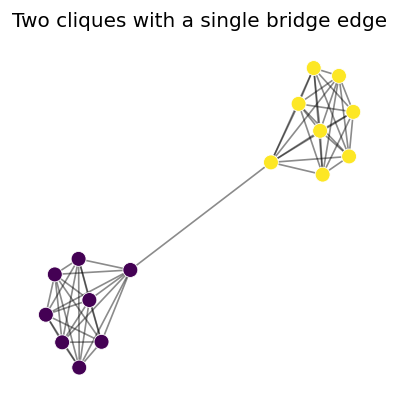

Toy graph: 16 nodes, 57 edges
Modularity of true partition: 0.4825


In [11]:
n1 = n2 = 8

G1 = nx.complete_graph(n1)
G2 = nx.complete_graph(range(n1, n1 + n2))
G_toy = nx.compose(G1, G2)
# A single "bridge" edge between the two cliques
G_toy.add_edge(0, n1)


true_comms = [set(range(0, 8)), set(range(8, 16))]

ax, pos = draw_partition(G_toy, true_comms, title="Two cliques with a single bridge edge")
plt.show()

print("Toy graph:", G_toy.number_of_nodes(), "nodes,", G_toy.number_of_edges(), "edges")
print("Modularity of true partition:", round(safe_modularity(G_toy, true_comms), 4))

### Your turn (quick): try a *bad* partition

Make a partition that mixes nodes from both cliques and see modularity drop.

Hint: build two sets like:
- `bad1 = {0,1,2,3,8,9,10,11}`
- `bad2 = rest`

Then compute `safe_modularity(G_toy, [bad1, bad2])`.

In [13]:
# bad1 = {}
# bad2 = set(G_toy.nodes()) - bad1


# bad_comms = [bad1, bad2]

# ax, _ = draw_partition(G_toy, bad_comms, pos=pos, title="A mixed (bad) partition")
# plt.show()

# print("Bad partition modularity:", round(safe_modularity(G_toy, bad_comms), 4))


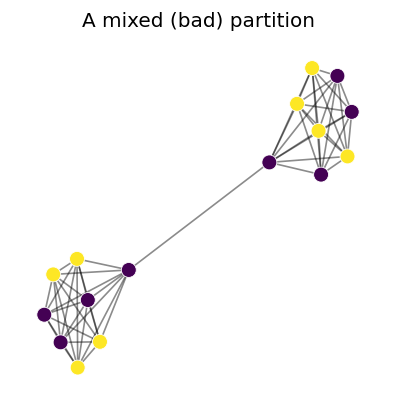

Bad partition modularity: -0.0616


In [14]:
# One intentionally-bad partition
bad1 = {0,1,2,3,8,9,10,11}
bad2 = set(G_toy.nodes()) - bad1
bad_comms = [bad1, bad2]

ax, _ = draw_partition(G_toy, bad_comms, pos=pos, title="A mixed (bad) partition")
plt.show()

print("Bad partition modularity:", round(safe_modularity(G_toy, bad_comms), 4))


### Modularity variants and graph types: weighted, directed, bipartite

Up to now we've mostly assumed a *simple undirected* graph. In research, you'll often see:
- **weighted** edges: strength / frequency / capacity
- **directed** edges: citations, follower networks, money flow
- **bipartite** graphs: people–events, authors–papers, users–items

Modularity has natural generalizations for **weighted** and **directed** graphs (and NetworkX supports both).
For **bipartite** graphs, *standard* modularity on the raw bipartite network is usually the wrong objective —
you either use a bipartite-specific modularity (e.g., Barber 2007) or you project to one mode (with caveats).


__________
## Method: Girvan Newman

The Girvan-Newman method [1] is a *divisive* algorithm that iteratively removes the edges connecting the different clusters until the optimal partition is found and the communities are fully isolated. The algorithm calculates a score for each edge (in this case, *edge betweenness*, though others could have been considered), ranks these scores, and iteratively removes them from the graph. At each iteration, the modularity of the partition of (dis)connected components is measured. We repeat this step until the graph has no edges, and the partition with the highest modularity is chosen.

![](images/girvan_newman.png)

[1] Girvan M. & Newman M.E.J. (2002). **Community structure in social and biological networks**. Proceedings of the National Academy of Sciences, 99, 7821–7826. https://doi.org/10.1073/pnas.122653799.

In [18]:
import networkx as nx
from networkx.algorithms.community import modularity
import community

def girvan_newman(H, output='dict'):
    """
    Implements the Girvan-Newman algorithm for detecting communities in a graph.
    
    The Girvan-Newman method works by iteratively removing edges from the graph 
    based on their edge betweenness centrality, which is a measure of the frequency 
    with which edges appear on the shortest paths between pairs of nodes. As edges 
    with high centrality values are removed, the graph breaks down into smaller 
    connected components, each representing a community.
    
    Parameters:
    -----------
    H : networkx.Graph
        The input graph on which to perform community detection.
    
    output : strong, optional (default='dict')
        'dict'  - the algorithm will return a dictionary where the keys correspond to
                  nodes and values are the community label
        'lists' - a list of lists of length n_comms will be returned, such that the ith
                  element of the list contains a nodelist of nodes that are assigned to
                  community i
        'list'  - a list of community assignments, in the same order as G.nodes()
    
    Returns:
    --------
    dict:
        A dictionary or similar object where the keys are node identifiers and
        the values are  community labels (integers), indicating which
        community each node belongs to.
    
    
    Notes:
    ------
    - Modularity is a measure of the strength of the division of a network into 
      communities. Higher values indicate stronger community structure.
    
    - The Girvan-Newman algorithm is computationally expensive (O(n*m^2), where n 
      is the number of nodes and m is the number of edges), making it impractical 
      for very large graphs.
    
    Example:
    --------
    >>> import networkx as nx
    >>> G = nx.karate_club_graph()
    >>> partition = girvan_newman(G)
    >>> for node, community in partition.items():
    >>>     print(f"Node {node} belongs to community {community}")
    """

    # Make a copy of the graph so we don't modify the original graph
    G = H.copy()

    # Initialize variables to track the best partition and modularity
    best_partition = None
    best_modularity = -1

    # Keep removing edges until all components are disconnected
    while G.number_of_edges() > 0:
        # Compute edge betweenness centrality for all edges
        edge_betweenness = nx.edge_betweenness_centrality(G)

        # Find the edge with the highest betweenness
        max_edge = max(edge_betweenness, key=edge_betweenness.get)

        # Remove the edge with the highest betweenness
        G.remove_edge(*max_edge)

        # Find connected components (each component is a community)
        components = list(nx.connected_components(G))

        # Assign community labels to nodes
        community_dict = {}
        for i, component in enumerate(components):
            for node in component:
                community_dict[node] = i

        # Compute modularity for the current partition on the original graph
        try:
            current_modularity = modularity(H, components)
        except ZeroDivisionError:
            # If division by zero occurs, set modularity to 0
            current_modularity = 0

        # If this modularity is better than the best so far, store it
        if current_modularity > best_modularity:
            best_modularity = current_modularity
            best_partition = community_dict.copy()

    best_partition = {i:best_partition[i] for i in G.nodes()}
    # Return the best partition
    if output == 'dict':
        return best_partition

    if output == 'list':
        return list(best_partition.values())
        
    if output == 'lists':
        comm_out = [[] for i in np.unique(list(best_partition.values()))]
        for i,j in best_partition.items():
            comm_out[j].append(i)
        return comm_out

Best Modularity: 0.40129848783694944


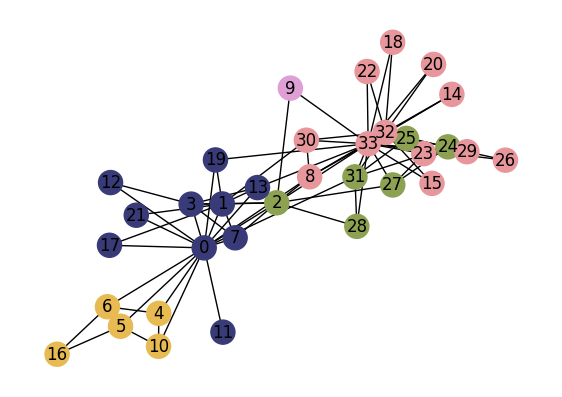

In [20]:
# Create a graph
G = nx.karate_club_graph()
pos = nx.spring_layout(G)

# Run the Girvan-Newman algorithm with modularity tracking
best_partition = girvan_newman(G)

# Output the best modularity score
print("Best Modularity:", calculate_modularity(G, best_partition))

unique_comms = np.unique(list(best_partition.values()))
comm_colors = plt.cm.tab20b(np.linspace(0,1,len(unique_comms)))
comm_color_dict = dict(zip(unique_comms, comm_colors))

node_colors = [comm_color_dict[best_partition[i]] for i in K.nodes]

fig, ax = plt.subplots(1,1,figsize=(7,5),dpi=100)

nx.draw(G, pos=pos, node_color=node_colors, with_labels=True, ax=ax)

plt.show()

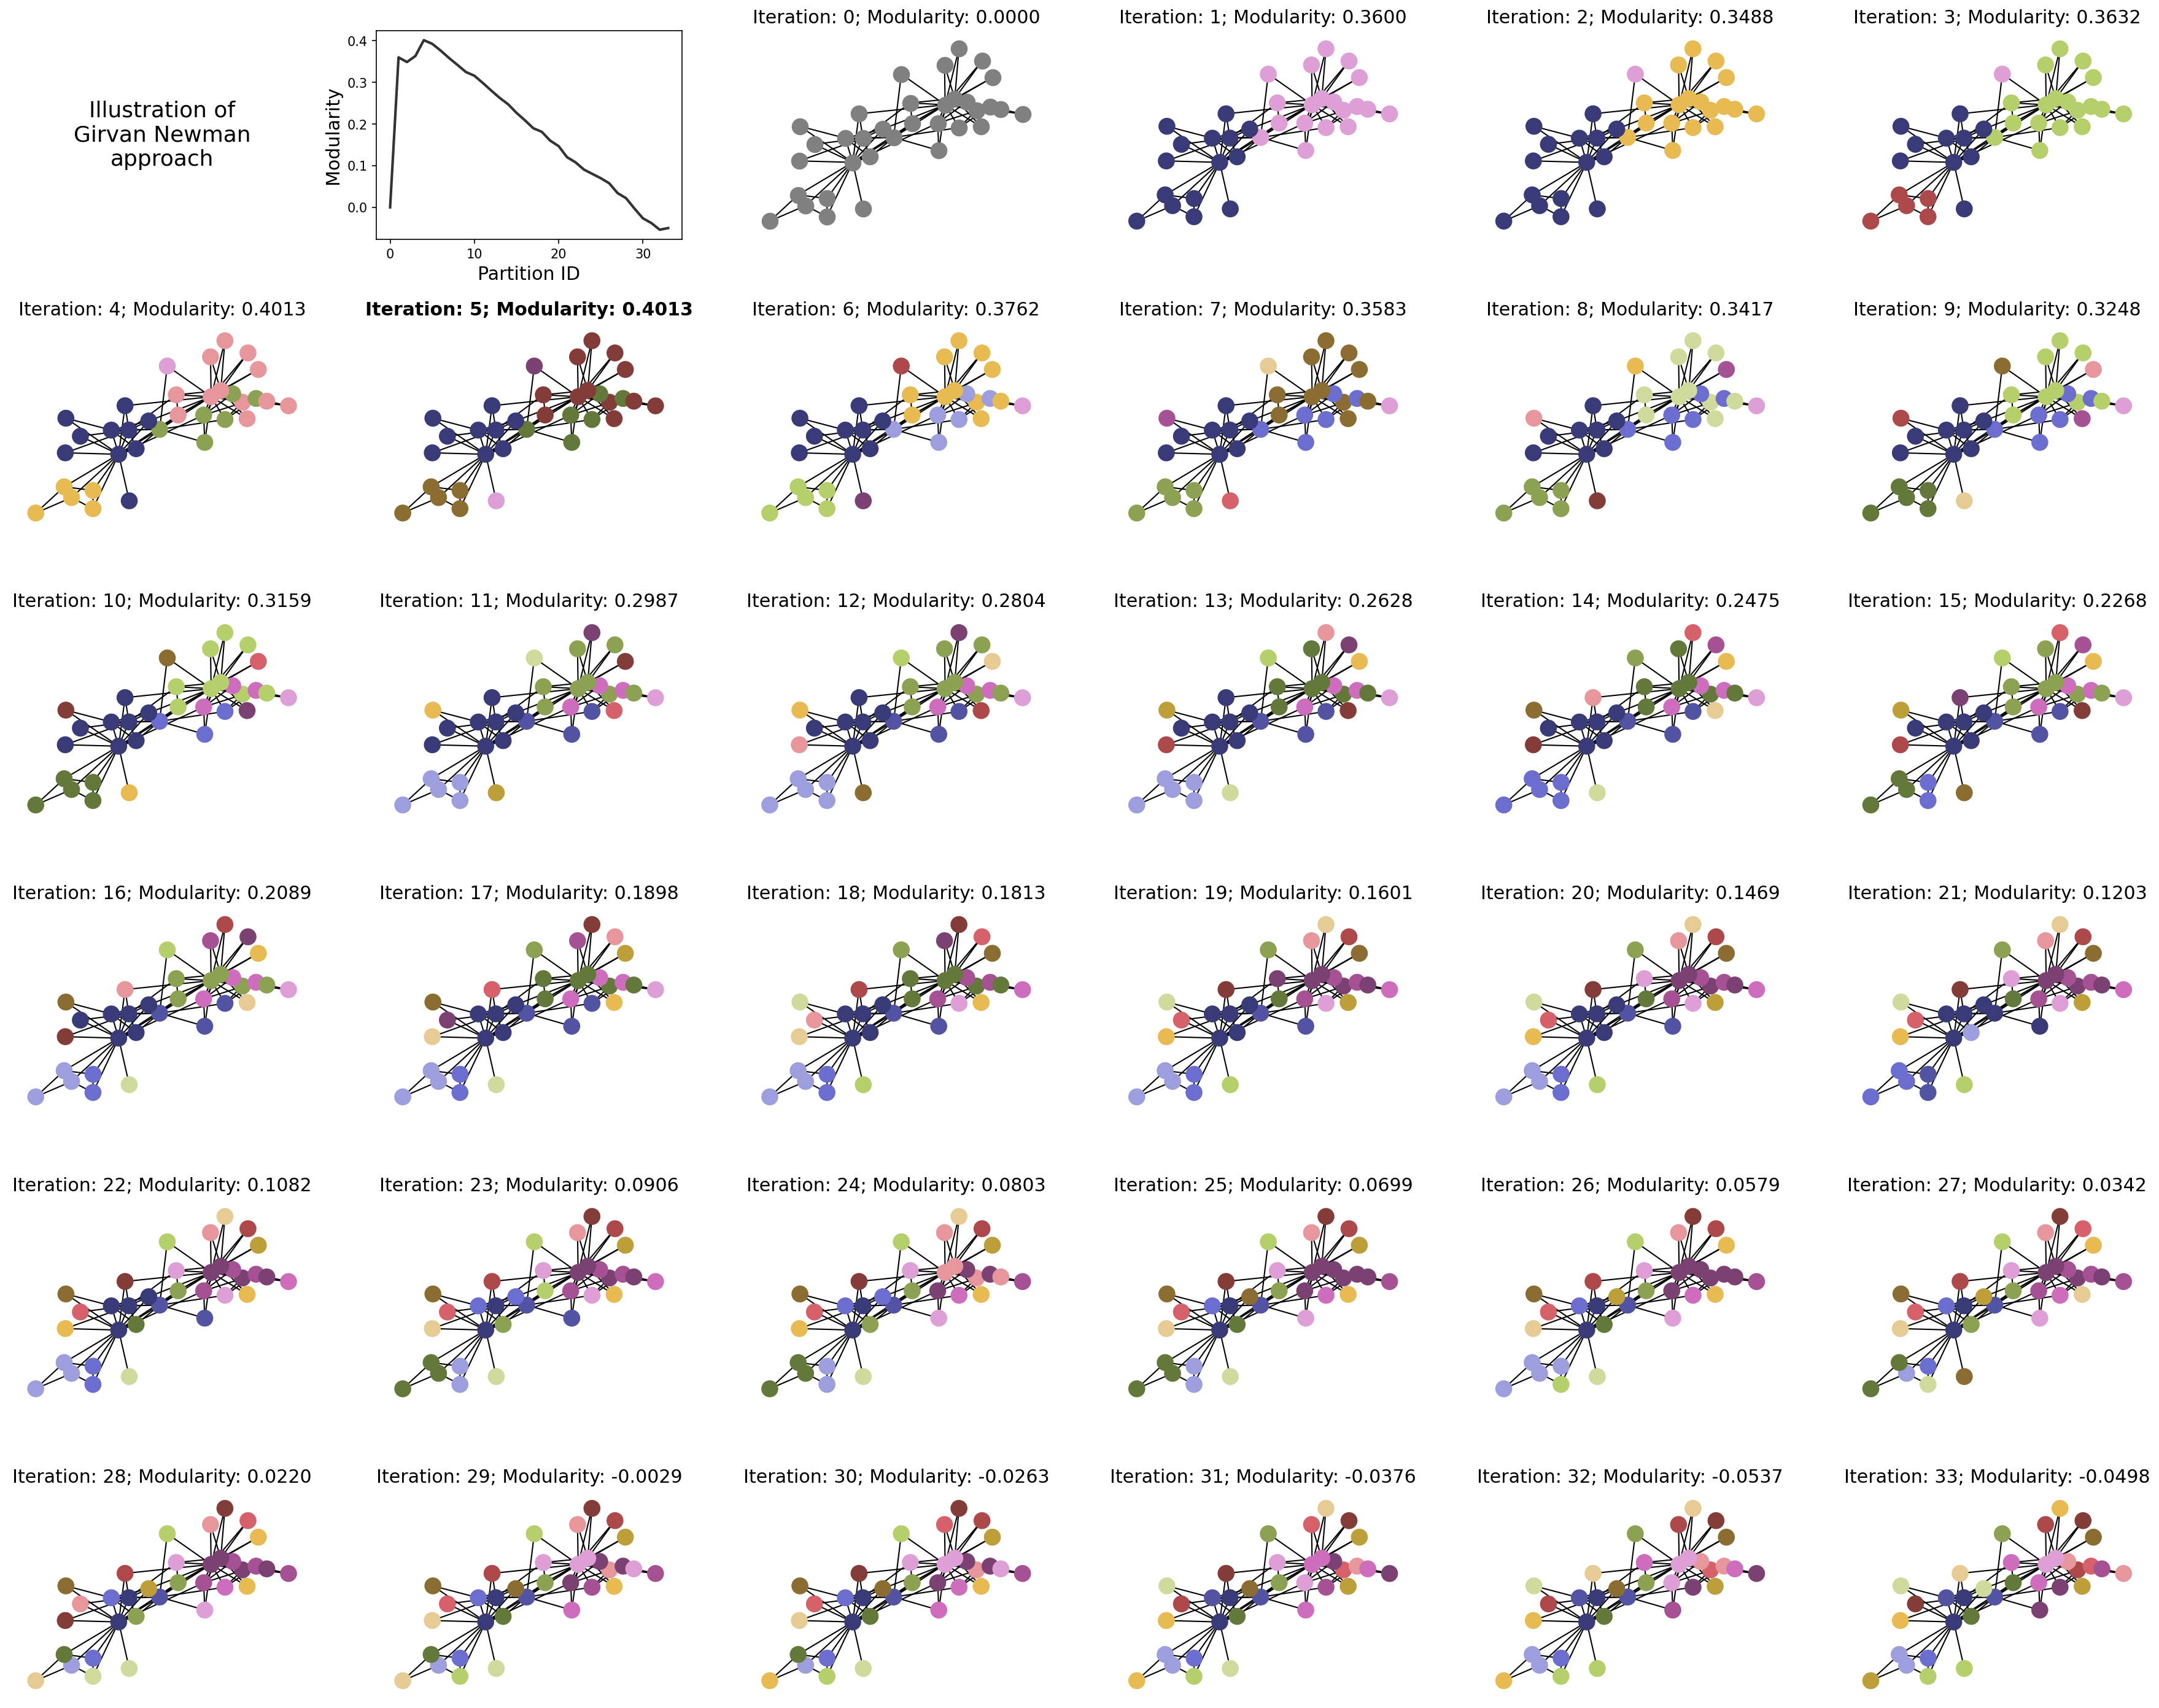

In [21]:
import itertools as it
w = 5.0
h = 4.0
nrows = 6
ncols = 6
tups = list(it.product(range(nrows), range(ncols)))

fig, ax = plt.subplots(nrows, ncols, figsize=(w*ncols,h*nrows), dpi=150)
plt.subplots_adjust(wspace=0.2, hspace=0.4)


gn = list(nx.community.girvan_newman(G))
best_partition = {i:i for i in G.nodes()}
best_modularity = 0
mods = [0.0]

for ii,gn_i in enumerate(gn):
    part_i = {i:0 for i in G.nodes()}
    node_comms_i = list(gn_i)
    ncomms_i = list(range(len(node_comms_i)))
    for ix, p_i in enumerate(gn_i):
        for v_i in p_i:
            part_i[v_i] = ncomms_i[ix]

    mod_i = calculate_modularity(G, part_i)
    mods.append(mod_i)
    if mod_i > best_modularity:
        best_partition = part_i.copy()
        best_modularity = mod_i

    unique_comms = np.unique(list(part_i.values()))
    comm_colors = plt.cm.tab20b(np.linspace(0,1,len(unique_comms)))
    comm_color_dict = dict(zip(unique_comms, comm_colors))

    node_colors = [comm_color_dict[part_i[i]] for i in G.nodes]
    nx.draw(G, pos, node_color=node_colors, node_size=150,
            ax=ax[tups[ii+3]])
    
    ax[tups[ii+3]].set_title('Iteration: %i; Modularity: %.4f'%(ii+1,mod_i),
                             fontsize='x-large')



ax[tups[np.argmax(mods)+3]].set_title('Iteration: %i; Modularity: %.4f'%(np.argmax(mods)+1,best_modularity),
                         fontsize='x-large', fontweight='bold')
    

ax[tups[0]].text(0.5,0.5,'Illustration of\nGirvan Newman\napproach',
                 ha='center',va='center',fontsize='xx-large')
ax[tups[0]].set_xlim(0,1)
ax[tups[0]].set_ylim(0,1)
ax[tups[0]].set_axis_off()

ax[tups[1]].plot(mods, lw=2, color='.2')
ax[tups[1]].set_xlabel('Partition ID', fontsize='x-large')
ax[tups[1]].set_ylabel('Modularity', fontsize='x-large')

ax[tups[2]].set_title('Iteration: %i; Modularity: %.4f'%(0,0.0),
                             fontsize='x-large')
nx.draw(G, pos, node_color='.5', node_size=150,
        ax=ax[tups[2]])
ax[tups[2]].set_axis_off()

    

plt.show()

_________
#### Modularity Landscape

![](images/good_montjoye_clauset.png)

Figure: Low-dimensional visualization of the modularity landscape for the metabolic network of the *spirochete Treponema pallidum*. Partitions with high modularity have high *degeneracy*, which can be seen due to the large number of local maxima all with approximately the same modularity (see the red inset above the landscape). These modularity values in the "table top" of the landscape all are approximately equivalent to the maximum modularity, despite the fact that they correspond to different partitions. *Figure from Good, de Montjoye & Clauset (2009)*.

Many heuristics give good estimates for the modularity maximization problem, however this can be due to the fact that there is an high degeneracy of large modularity partitions. This problem is particularly severe on graphs with hierarchical community structure (i.e. in many real world networks).

Another problem is that having "high" modularity does not imply that the partitioning is good: i.e. random graphs might have high modularity even when there is no community structure in them. Indeed, in the standard modularity formulation we are only considering the average (i.e. expected) value of connections between nodes, but we are not considering possible fluctuations. One possible solution is to look at the ___z-score___ of the modularity value after having generated multiple realizations of the null model:

$$ Q_z = \frac{Q_{max} - \langle Q \rangle_{null}}{\sigma(Q)_{null}} $$

___________

________

## Method: Louvain Algorithm

In the years that followed the Girvan-Newman approach, we saw dozens of new community detection algorithms emerge. One that persisted for several years as a popular approach is called the ***Louvain Algorithn*** [1]. It is implemented as follows:


1. **Initialization:** Each node starts as its own community.

2. **Phase 1 - Modularity Optimization:**
- For each node $i$, the algorithm evaluates the gain in modularity from moving that node to each of its neighbors' $j$ communities.
- The node is placed in the community that maximizes the modularity gain. If no such move increases modularity, the node stays in its current community.

3. **Phase 2 - Community Aggregation:**
- Once no further modularity gains can be made, each community is collapsed into a single node, creating a new, smaller network.
- The process repeats until modularity can no longer be improved.

4. **Output:** The algorithm outputs the community structure that maximizes the modularity.

![](images/louvain.png)

[1] Blondel, V. D., Guillaume, J. L., Lambiotte, R., & Lefebvre, E. (2008). Fast unfolding of communities in large networks. Journal of Statistical Mechanics, 2008(10), P10008. https://doi.org/10.1088/1742-5468/2008/10/P10008

***Why it is efficient?***

$$ \Delta Q =  \left[ \frac{S_{C}^{in} + s_{i}^{in}}{2W} - \left( \frac{S_{C}^{tot} + s_{i}}{2W} \right)^2  \right]   -   \left[ \frac{S_{C}^{in}}{2W} - \left( \frac{S_{C}^{tot}}{2W} \right)^2 - \left( \frac{s_i}{2W} \right)^2  \right]  $$

where $s_i$ is the strength of node $i$, $s_{i,c}$ is the _internal_ strength of node $i$,$S_{C}^{in} = \sum_{i \in C} s_{i}^{in}$ is the _internal_ strength of cluster $C$, $S_{C}^{tot} = \sum_{i \in C} s_i$ is the total strength of cluster $C$, and $W$ is the sum of the weights of all the links in the network.

In practice, the complexity of this algorithm is approximagely $O(N \log N)$.

Below is an example of the (much more complicated!) functions involved in the Louvain method.

In [22]:
from collections import defaultdict
from random import shuffle, Random

def local_optimization_step(H, weight="weight", rng=None, verbose=False, tol=1e-12):
    """
    Greedy local moving step: repeatedly move nodes into neighbor communities
    whenever modularity increases.
    """
    if rng is None:
        rng = Random()

    partition = dict(nx.get_node_attributes(H, "community"))
    # Ensure all nodes have a community label
    for n in H.nodes():
        partition.setdefault(n, n)

    Q = calculate_modularity(H, partition, weight=weight)

    nodes = list(H.nodes())
    rng.shuffle(nodes)

    iteration = 0
    improved = True
    while improved:
        iteration += 1
        if verbose:
            print(f"Iteration: {iteration}")

        improved = False

        for node_i in nodes:
            cur_comm = partition[node_i]

            # unique candidate communities = communities of neighbors
            candidate_comms = {partition[nbr] for nbr in H.neighbors(node_i)}

            best_comm = cur_comm
            best_Q = Q

            for comm in candidate_comms:
                if comm == cur_comm:
                    continue

                partition[node_i] = comm
                Q_new = calculate_modularity(H, partition, weight=weight)

                if Q_new > best_Q + tol:
                    best_Q = Q_new
                    best_comm = comm

            partition[node_i] = best_comm
            if best_comm != cur_comm:
                Q = best_Q
                improved = True

        rng.shuffle(nodes)

    # write back to graph attributes
    nx.set_node_attributes(H, partition, "community")
    return Q


def network_aggregation_step(H, weight="weight"):
    """
    Collapse each community into a super-node.
    - Edges between communities are summed.
    - Internal edges become self-loops.
    - IMPORTANT: isolated communities must remain as nodes.
    """
    part = dict(nx.get_node_attributes(H, "community"))
    communities = set(part.values())

    H_new = nx.Graph()
    H_new.add_nodes_from(communities)  # keep isolated communities

    # accumulate weights between community pairs (order-free)
    edge_w = defaultdict(float)
    for u, v, attr in H.edges(data=True):
        w = attr.get(weight, 1.0)
        cu, cv = part[u], part[v]
        key = frozenset((cu, cv))
        edge_w[key] += w

    for key, w in edge_w.items():
        if len(key) == 1:
            (c,) = tuple(key)
            H_new.add_edge(c, c, **{weight: w})
        else:
            c1, c2 = tuple(key)
            H_new.add_edge(c1, c2, **{weight: w})

    # each node starts as its own community at the next level
    nx.set_node_attributes(H_new, {c: c for c in H_new.nodes()}, "community")
    return H_new


def reindex_communities(partition):
    """
    Deterministic reindexing: assigns compact IDs 0..K-1.
    """
    mapping = {}
    out = {}

    # use repr() ordering so mixed-type node labels don't crash sorted()
    for node in sorted(partition.keys(), key=lambda x: repr(x)):
        comm = partition[node]
        if comm not in mapping:
            mapping[comm] = len(mapping)
        out[node] = mapping[comm]

    return out


def louvain_method(G, init=None, weight="weight", seed=None, verbose=False, tol=1e-12):
    """
    Louvain (classic, gamma=1) for undirected graphs.
    Uses exact modularity recomputation in the local move step (slow but simple).

    Returns: dict node -> community_id (reindexed to 0..K-1)
    """
    if G.is_directed():
        raise nx.NetworkXError("This implementation expects an undirected graph.")

    H = G.copy()

    # Ensure every edge has a weight; do NOT overwrite existing weights
    for u, v, attr in H.edges(data=True):
        attr.setdefault(weight, 1.0)
        if attr[weight] < 0:
            raise ValueError("Standard Louvain modularity assumes non-negative edge weights.")

    # Initial partition
    if init is not None:
        if set(init.keys()) != set(H.nodes()):
            raise ValueError("init must map every node in G to a community label.")
        partition0 = init.copy()
    else:
        partition0 = {node: i for i, node in enumerate(H.nodes())}

    nx.set_node_attributes(H, partition0, "community")

    # Map "current level nodes" -> original nodes
    aggregate_to_original = {node: [node] for node in H.nodes()}
    best_partition = partition0.copy()

    rng = Random(seed)

    while True:
        Q_before = calculate_modularity(H, dict(nx.get_node_attributes(H, "community")), weight=weight)
        Q_after = local_optimization_step(H, weight=weight, rng=rng, verbose=verbose, tol=tol)

        part_level = dict(nx.get_node_attributes(H, "community"))
        num_comms = len(set(part_level.values()))

        # If no merges happened (or no meaningful modularity gain), we’re done
        if num_comms == H.number_of_nodes() or Q_after <= Q_before + tol:
            break

        # Update mapping back to original nodes
        old_map = aggregate_to_original
        aggregate_to_original = defaultdict(list)

        for old_node, new_comm in part_level.items():
            for orig in old_map[old_node]:
                aggregate_to_original[new_comm].append(orig)
                best_partition[orig] = new_comm

        # Aggregate and continue
        H = network_aggregation_step(H, weight=weight)
        aggregate_to_original = dict(aggregate_to_original)

    return reindex_communities(best_partition)

______________
### Challenges in Community Detection

Despite the wide use of community detection, several challenges persist:

- **Resolution Limit**: Modularity-based methods can fail to detect small communities due to the resolution limit, where small but dense communities might be merged into larger ones.
- **Overlapping Communities**: Many real-world networks contain overlapping communities (e.g., a person belonging to multiple social groups), but traditional algorithms are typically designed to find disjoint partitions.
- **Computational Complexity**: For very large networks, many algorithms become computationally prohibitive. Efficient approximations or parallel implementations are often required.
- **Ground Truth Validation**: In many networks, the "ground truth" community structure is unknown, making it difficult to validate or compare different community detection methods.


## Punchline: These methods all have a common failing
... and it's the topic of Part 2

___________
## Part 2: Trouble in Modularity Paradise...

Let's start with two exercises to motivate today's lesson, both of which point to a deep concern in the utility of *modularity* as a graph property and as a measure to optimize over when identifying communities in networks.

Recall that the modularity, $Q$, of a given partition $C$ of our adjacency matrix $A$ is:

$$Q (A,C) = \frac{1}{2M} \sum_{i,j} \left( A_{ij} - \frac{k_i k_j}{2M} \right) \delta (C_i,C_j) $$

The key idea behind this measure was that to calculate the number of within-community edges that exist above and beyond what we'd expect just based on nodes' degrees. What follows is the assumption (or, rather, the hope) that we should not find community structure in Erdős-Rényi random graphs. Let's explore this with two exercises where we run a modularity-maximizing community detection algorithm over hundreds of ER graphs.

Using a graph of size $N=200$, loop over various values for $p$ to create many ER graphs. Compute the `community.best_partition` of each of these, and store the following:

1. The modularity of the `best_partition` for each randomly generated graph.
2. The number of communities detected in each partition.

In [2]:
import community

plist = np.logspace(-3.5,0,501)
N = 200
modularity_out = []
num_commun_out = []

for p in plist:
    G_i = nx.erdos_renyi_graph(N,p)
    part_i = community.best_partition(G_i)
    num_commun_out.append(len(set(part_i.values())))
    modularity_out.append(community.modularity(part_i, G_i))

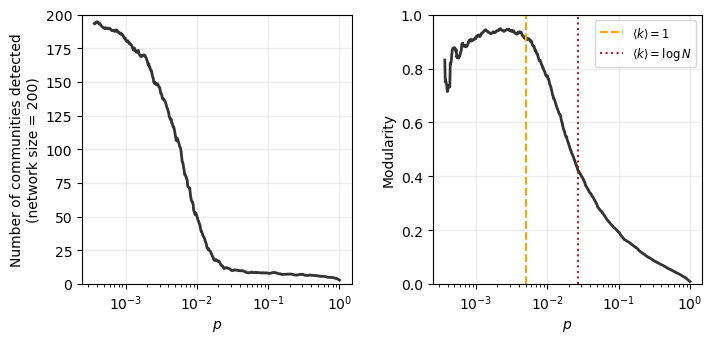

In [3]:
fig, ax = plt.subplots(1,2,figsize=(8,3.5),dpi=100)
plt.subplots_adjust(wspace=0.3)

ax[0].semilogx(plist, pd.Series(num_commun_out).rolling(window=10).mean(), color='.2', lw=2)
ax[1].semilogx(plist, pd.Series(modularity_out).rolling(window=10).mean(), color='.2', lw=2)

ax[0].set_ylabel('Number of communities detected\n(network size = 200)')
ax[0].set_xlabel(r'$p$')
ax[0].set_ylim(0,N)

ax[1].vlines(1/(N-1),0,1,ls='--',color='orange',label=r'$\langle k \rangle = 1$')
ax[1].vlines(np.log(N)/(N-1),0,1,ls=':',color='firebrick',label=r'$\langle k \rangle = \log N$')
ax[1].legend(fontsize='small')
ax[1].set_ylabel('Modularity')
ax[1].set_xlabel(r'$p$')
ax[1].set_ylim(0,1)
ax[0].grid(alpha=0.25, lw=1, color='.75')
ax[1].grid(alpha=0.25, lw=1, color='.75')

plt.show()

What does this mean?

What does this mean for real networks? Let's find out.
________
For reference, let's load the PolBlogs datasets from class 2 and 3:

In [4]:
rc('axes', fc='w')
rc('figure', fc='w')
rc('savefig', fc='w')

digraph = nx.DiGraph()
with open('data/polblogs_nodes_class.tsv','r') as fp:
    for line in fp:
        node_id, node_label, node_political = line.strip().split('\t')
        political_orientation = 'liberal' if node_political == '0' else 'conservative'
        digraph.add_node(node_id, website=node_label, political_orientation=political_orientation)
        
with open('data/polblogs_edges_class.tsv','r') as fp:
    for line in fp:
        source_node_id, target_node_id = line.strip().split('\t')
        digraph.add_edge(source_node_id, target_node_id)

# just select the largest strongly connected component, and 
sccs = sorted(nx.strongly_connected_components(digraph), key=len, reverse=True)
G = nx.to_undirected(digraph.subgraph(sccs[0]))

# get the political leanings and assign them to colors
cols = ["#c5c03a","#7275d7","#8fb755","#c361bd","#5ec384","#d3537a","#3fe0d8","#cb6b3b"]
leanings = nx.get_node_attributes(G,'political_orientation')
node_colors = [cols[0] if leaning=='conservative' else cols[1] \
               for leaning in leanings.values()]

edge_colors = '.4'
pos = nx.spring_layout(G)

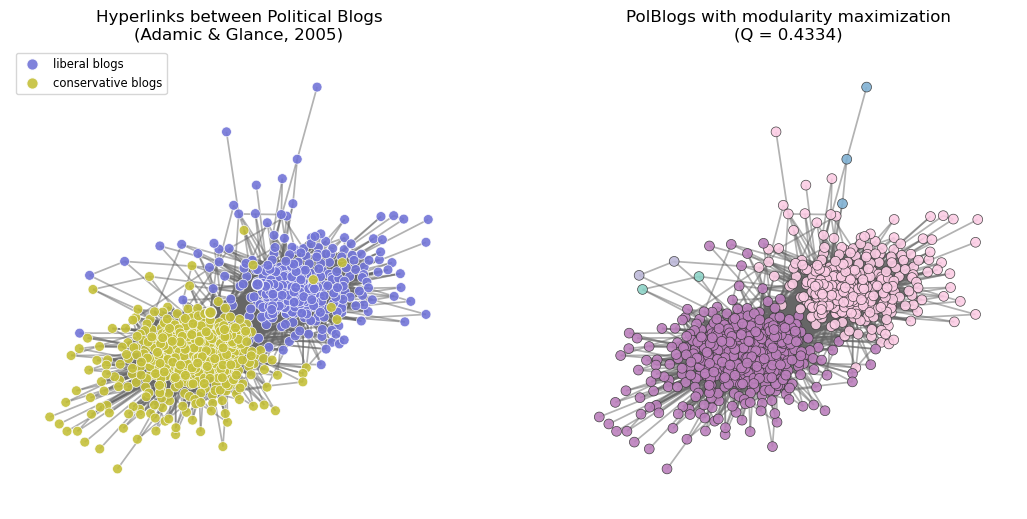

In [5]:
fig, ax = plt.subplots(1,2,figsize=(13,6),dpi=100)

nx.draw_networkx_nodes(G, pos, node_color=node_colors,
                       node_size=50, edgecolors='w', alpha=0.9, linewidths=0.5, ax=ax[0])
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=1.25, alpha=0.5, ax=ax[0])
ax[0].set_title('Hyperlinks between Political Blogs\n(Adamic & Glance, 2005)', fontsize='large')
ax[0].set_axis_off()

legend_node0 = '0'
legend_node1 = '1000'
nx.draw_networkx_nodes(G, {legend_node0:pos[legend_node0]}, nodelist=[legend_node0], 
                       label='liberal blogs', 
                       node_color=cols[1], node_size=70, edgecolors='w', alpha=0.9, ax=ax[0])
nx.draw_networkx_nodes(G, {legend_node1:pos[legend_node1]}, nodelist=[legend_node1], 
                       label='conservative blogs',
                       node_color=cols[0], node_size=70, edgecolors='w', alpha=0.9, ax=ax[0])
ax[0].legend(fontsize='small')


part = community.best_partition(G)
ncs = plt.cm.Set3([i/len(set(part.values())) for i in part.values()])

nx.draw_networkx_nodes(G, pos, node_color=ncs,
                       node_size=50, edgecolors='.2', alpha=0.9, linewidths=0.5, ax=ax[1])
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=1.25, alpha=0.5, ax=ax[1])

ax[1].set_title('PolBlogs with modularity maximization\n(Q = %.4f)'%community.modularity(part,G),
                fontsize='large')
ax[1].set_axis_off()


plt.show()

Where does the PolBlogs modularity fall in our plot from above?

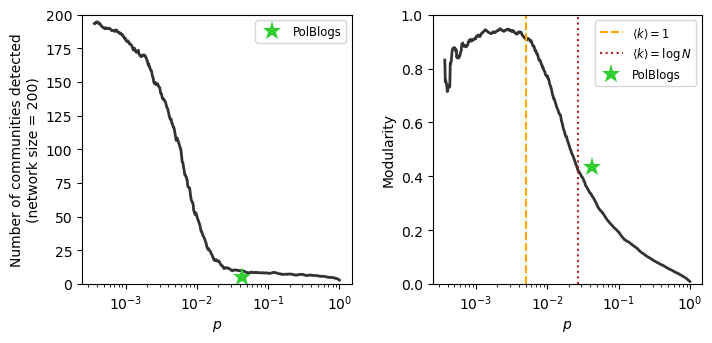

In [6]:
fig, ax = plt.subplots(1,2,figsize=(8,3.5),dpi=100)
plt.subplots_adjust(wspace=0.3)

ax[0].semilogx(plist, pd.Series(num_commun_out).rolling(window=10).mean(), color='.2', lw=2)
ax[0].semilogx([nx.density(G)], [len(set(part.values()))], '*',
               markersize=14, color='limegreen', label='PolBlogs', markeredgewidth=0)
ax[1].semilogx(plist, pd.Series(modularity_out).rolling(window=10).mean(), color='.2', lw=2)

ax[0].set_ylabel('Number of communities detected\n(network size = 200)')
ax[0].set_xlabel(r'$p$')
ax[0].set_ylim(0,N)
ax[0].legend(fontsize='small')

ax[1].vlines(1/(N-1),0,1,ls='--',color='orange',label=r'$\langle k \rangle = 1$')
ax[1].vlines(np.log(N)/(N-1),0,1,ls=':',color='firebrick',label=r'$\langle k \rangle = \log N$')
ax[1].semilogx([nx.density(G)],[community.modularity(part,G)], '*', 
               markersize=14, color='limegreen', label='PolBlogs', markeredgewidth=0)
ax[1].legend(fontsize='small')
ax[1].set_ylabel('Modularity')
ax[1].set_xlabel(r'$p$')
ax[1].set_ylim(0,1)


plt.show()

__________

This result is quite remarkable! And known for quite some time! Indeed in 2004, Roger Guimerà, Marta Sales-Pardo, and Luís Amaral published an article exploring this exact issue with the modularity measure.

- Guimera, R., Sales-Pardo, M., & Amaral, L.A.N. (2004). [Modularity from fluctuations in random graphs and complex networks](https://link.aps.org/doi/10.1103/PhysRevE.70.025101). *Physical Review E*, 70(2), 025101.

From the conclusion of their article: "...modularity in networks can arise due to a number of mechanisms. We have demonstrated that networks embedded in low-dimensional spaces have high modularity. We have also shown analytically and numerically that, surprisingly, **random graphs and scale-free networks have high modularity due to fluctuations in the establishment of links**."

They continue, arguing that many of the papers emerging in the early 2000s, which make theoretical claims about some real-world system based on measures of modularity (e.g. biological systems must have evolved to become modular) are potentially incomplete. These claims are based on network data that yields a partition with high ("high") modularity. Crucially, the authors note, this "**relies implicitly on the assumption that random graphs have low modularity.**"

![](images/modularity_from_fluctuations.png)

The authors conclude by arguing that their result paves the way for a notion of statistical significance for modularity (similar to what had been created for clustering coefficients, etc.). However, today, we revisit this paper for a different reason: to emphasize that the problems with modularity maximization don't just stop there (though these findings are particularly damning for a measure purporting to offer a useful and interpretable notion of how strong the community structure is in a graph).

_________

________
## Time Machine: From Blockmodels to Block Models

The transition from early stochastic blockmodels (SBMs), widely used in sociology and social network analysis during the 1970s and 80s, to contemporary versions (e.g. those pioneered by Tiago Peixoto), reflects an evolution from simple partitioning techniques to highly sophisticated probabilistic modeling frameworks for community detection and network analysis.

### Early Stochastic Blockmodels (1970s-1980s)
The original SBMs were first introduced in sociology and social network analysis (good starter references: [1,2]) as a way to model social structures and interactions between groups. These early SBMs were primarily focused on detecting communities, or blocks, where nodes within the same block were thought to share similar patterns of connections. These models assumed that each block or group had a specific probability of connection both within and between groups, and they were often used to study social networks, kinship structures, and small-scale organizational networks. Some key aspects of early SBMs:
- **Simple Probabilistic Assumptions**: Each node was assigned to a specific block, and the model defined fixed probabilities of edges occurring within and between blocks. These models typically used maximum likelihood estimation or similar methods to infer block memberships.
- **Limited Scalability**: Early SBMs were computationally expensive and difficult to apply to large networks due to the limited computing power at the time.
- **Static and Deterministic**: These models assumed fixed partitions of nodes and did not incorporate dynamic aspects of networks or node characteristics beyond group membership.

![](images/sbm_1970s.png)

#### References
- [1] White, H.C., Boorman, S.A., & Breiger, R.L. (1976). Social structure from multiple networks. I. Blockmodels of roles and positions. American Journal of Sociology, 81(4), 730-780. https://www.jstor.org/stable/2777596
- [2] Holland, P.W., Laskey, K.B., & Leinhardt, S. (1983). Stochastic blockmodels: First steps. *Social Networks*. 5(2), 109–137. https://doi.org/10.1016/0378-8733(83)90021-7
_____________

#### Canonical and Microcanonical SBMs


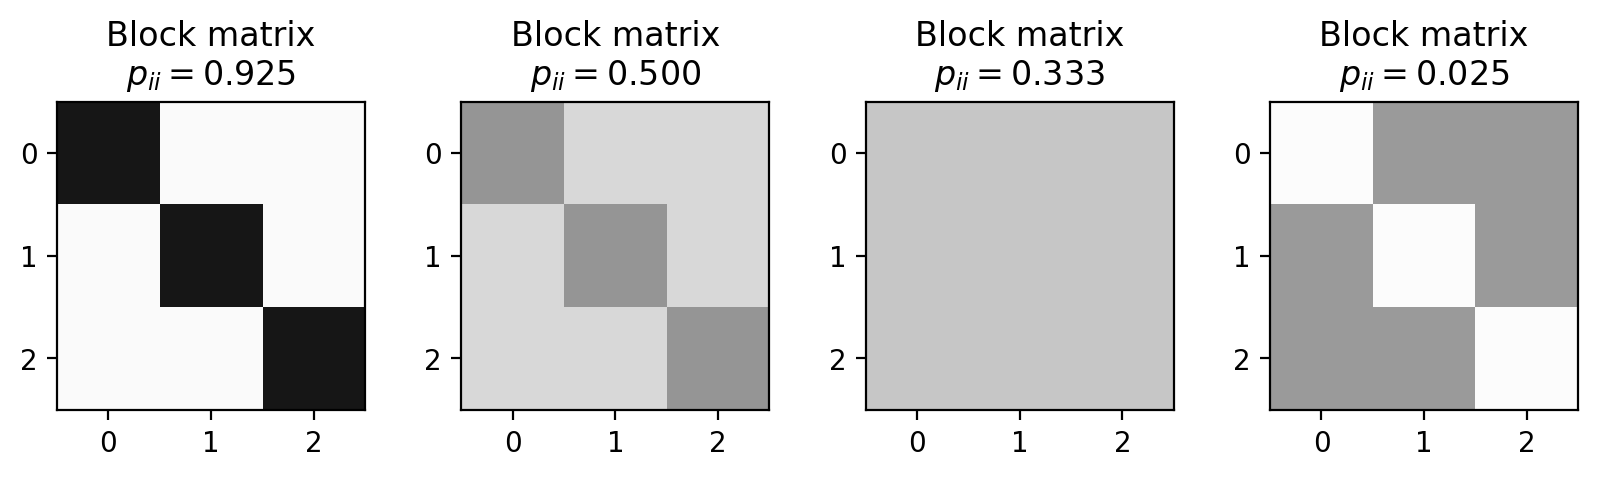

In [15]:
p_ii = 0.925
p_ij = (1-p_ii)/2
block_matrix1 = np.array([[p_ii, p_ij, p_ij], 
                          [p_ij, p_ii, p_ij], 
                          [p_ij, p_ij, p_ii]])

p_ii = 0.5
p_ij = (1-p_ii)/2
block_matrix2 = np.array([[p_ii, p_ij, p_ij], 
                          [p_ij, p_ii, p_ij], 
                          [p_ij, p_ij, p_ii]])

p_ii = 0.3333
p_ij = (1-p_ii)/2
block_matrix3 = np.array([[p_ii, p_ij, p_ij], 
                          [p_ij, p_ii, p_ij], 
                          [p_ij, p_ij, p_ii]])

p_ii = 0.025
p_ij = (1-p_ii)/2
block_matrix4 = np.array([[p_ii, p_ij, p_ij], 
                          [p_ij, p_ii, p_ij], 
                          [p_ij, p_ij, p_ii]])

plot_blocks = [block_matrix1, block_matrix2, block_matrix3, block_matrix4]
pii_list = [0.925, 0.5, 0.3333, 0.025]

fig, ax = plt.subplots(1,4,figsize=(10,2),dpi=200)

for i,b in enumerate(plot_blocks):
    ax[i].imshow(b, vmin=0, vmax=1, cmap='Greys')
    ax[i].set_title('Block matrix\n'+r"$p_{ii} = %.3f$"%(pii_list[i]))


plt.show()

In [16]:
# just for viz purposes, create a layout of the graph we want
N = 150
Gz = nx.ring_of_cliques(3, int(N/3))
pos = nx.kamada_kawai_layout(Gz)

#### "Canonical" Approach: G(n,p) analog
Note here that canonical is not used in the colloquial sense... It's a term from statistical mechanics that describes a system in thermal equilibrium with a heat bath at a fixed temperature. It refers to the collection of all possible microstates of a system, each assigned a probability based on the Boltzmann distribution. The term "canonical" here emphasizes that this ensemble is one of the standard, fundamental ways to describe the statistical properties of a system.

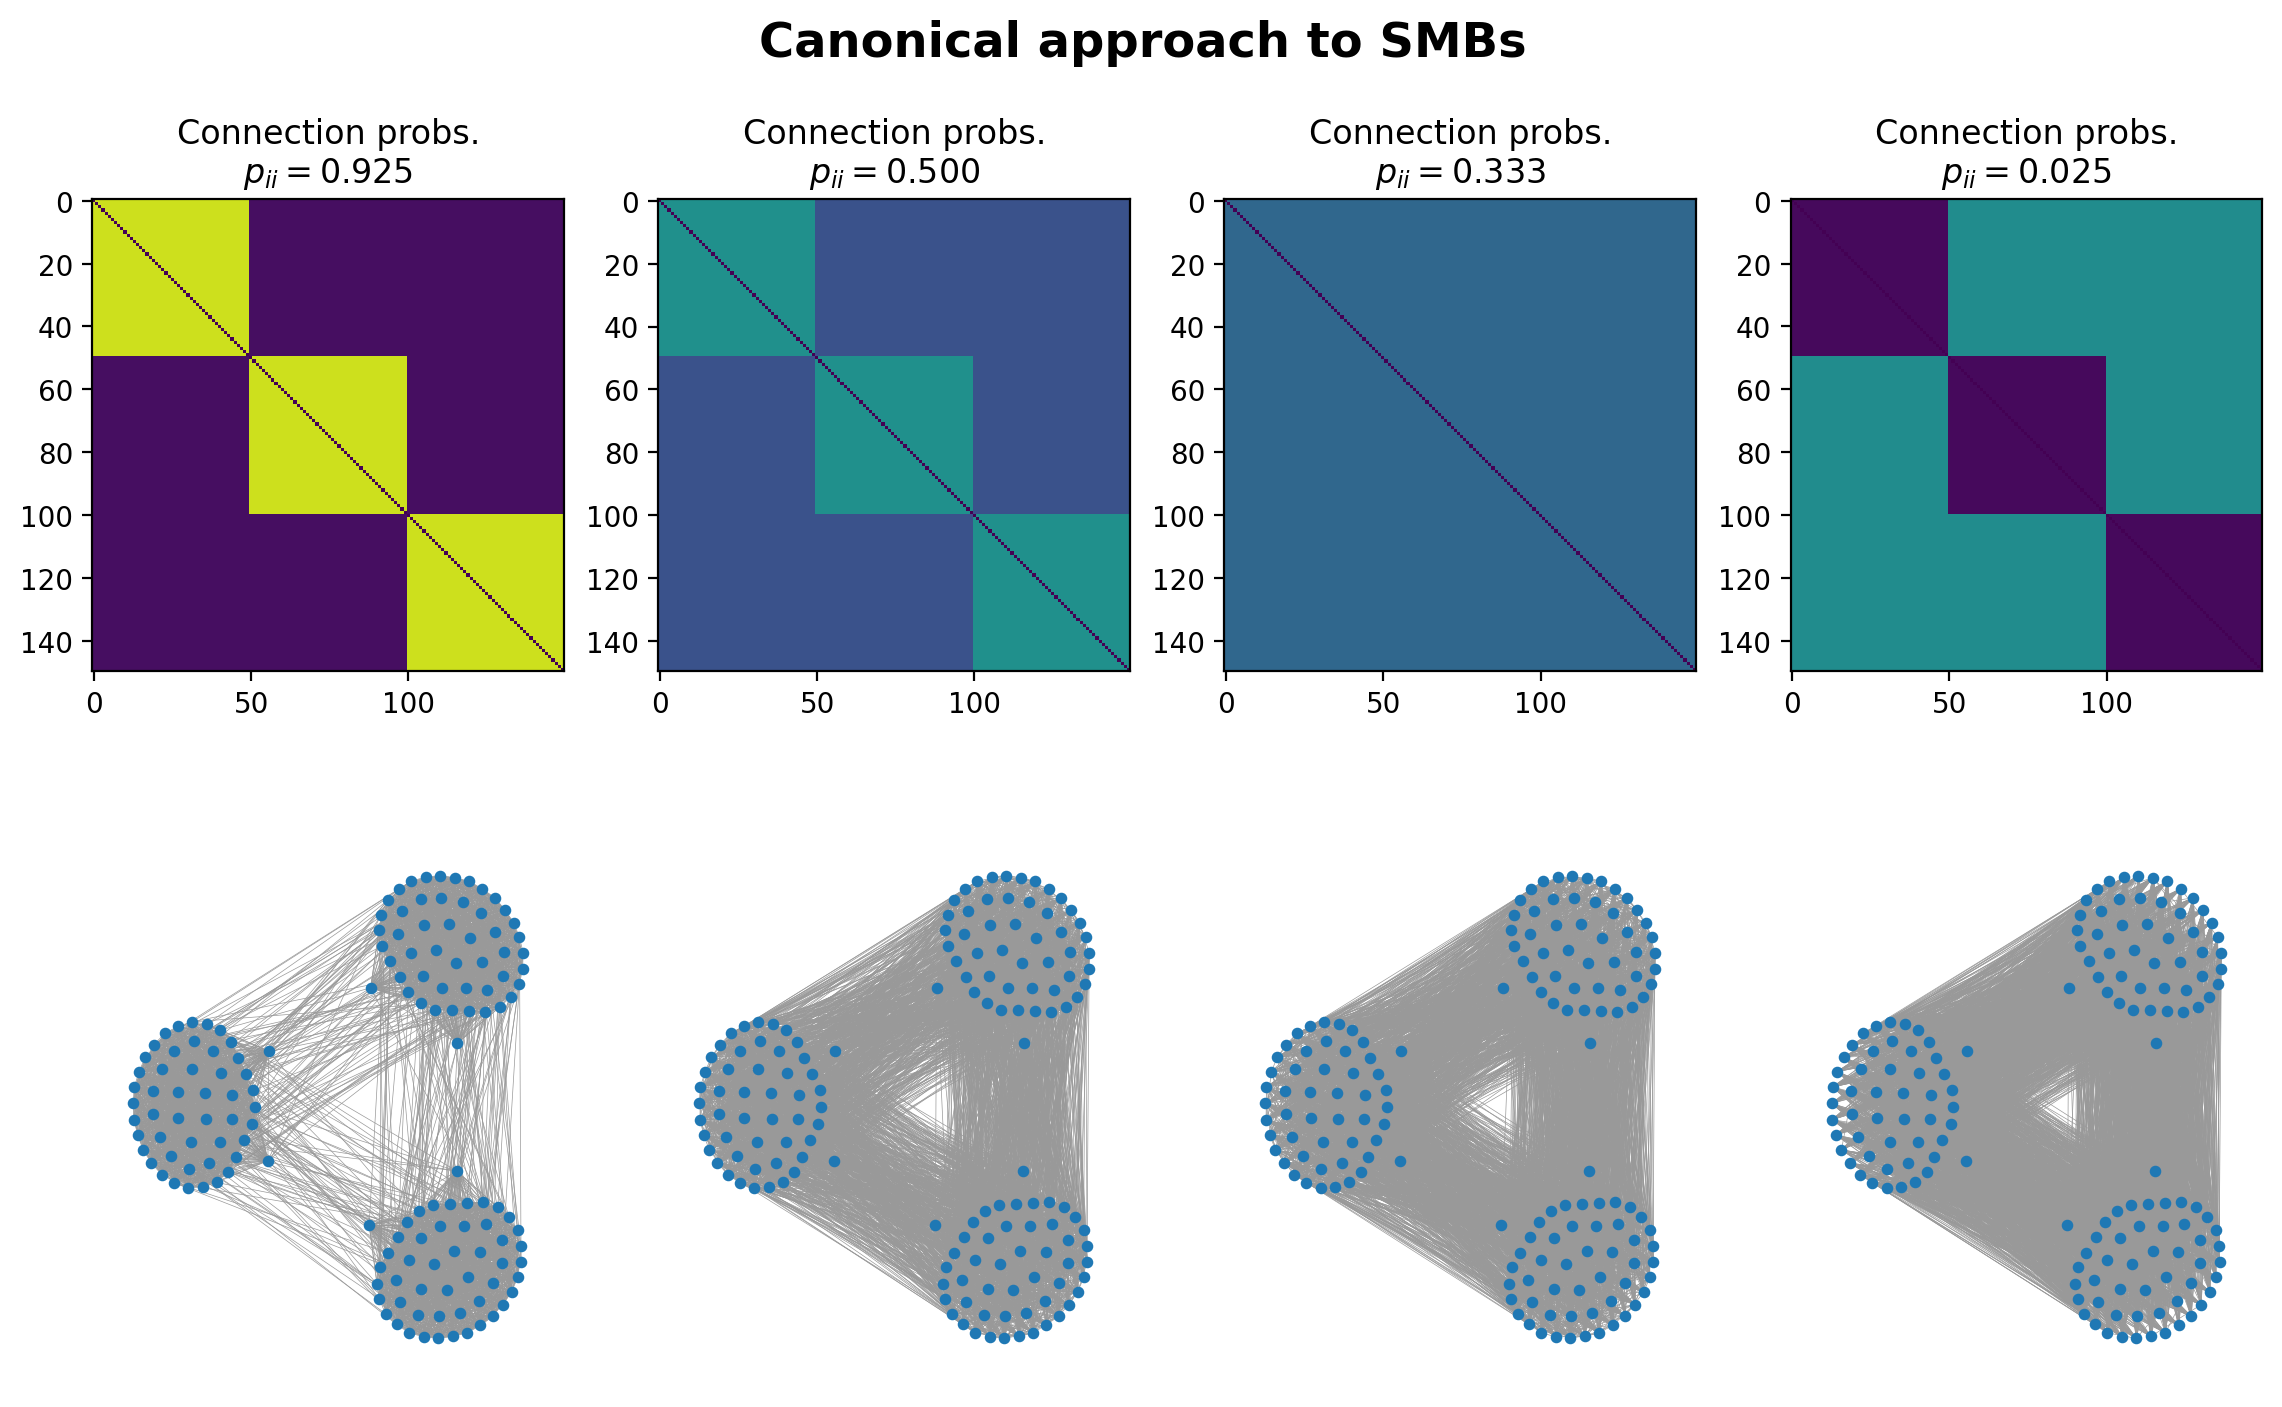

In [17]:
# assign nodes to blocks, then create a matrix of probabilities, p_ij, of node i connecting to node i
partition = [0]*int(N/3) + [1]*int(N/3) + [2]*int(N/3)

fig, ax = plt.subplots(2,4,figsize=(14,8),dpi=200)

for x, block_matrix_x in enumerate(plot_blocks):
    Pij = np.zeros((N,N))

    for i in range(N):
        for j in range(N):
            if i != j:
                b_i = partition[i]
                b_j = partition[j]
                Pij[i,j] = float(block_matrix_x[b_i,b_j])


    ax[(0,x)].imshow(Pij, vmin=0, vmax=1)
    ax[(0,x)].set_title('Connection probs.\n'+r"$p_{ii} = %.3f$"%(pii_list[x]))

    # now sample a random graph from this Pij matrix!
    G = nx.Graph()
    for i in range(N):
        for j in range(N):
            if i > j:
                if np.random.rand() < float(Pij[i,j]):
                    G.add_edge(i,j)
    
    nx.draw(G, pos=pos, node_size=10, width=0.25, edge_color='.6', ax=ax[(1,x)])

plt.suptitle('Canonical approach to SMBs', y=0.965, fontweight='bold', fontsize='xx-large')


plt.show()

#### Microcanonical Approach: G(n,m) analog
A "microcanonical" network ensemble is a collection of graphs that share fixed structural properties, often used to model or study networks with highly constrained features. The term microcanonical is applied because, analogous to physics, certain state variables are conserved, and we only consider networks that strictly obey these constraints.

In [18]:
import itertools as it

def create_graph_from_e(N, e):
    """
    Creates a graph with N nodes and assigns edges based on a predefined 
    edge budget matrix e1, where the nodes are divided into three blocks.

    The adjacency matrix `e1` specifies the number of edges to add between 
    each pair of blocks. Nodes are partitioned equally into three groups, 
    and edges are randomly assigned between and within these groups based 
    on the values in `e1`.

    Parameters:
    ----------
    N : int
        The total number of nodes in the graph. This should be divisible by 3 
        for an equal partitioning of nodes into three groups.

    Returns:
    -------
    G : networkx.Graph
        A graph object where nodes are partitioned into three groups and edges 
        are added based on the edge budget matrix.
    """

    # Create a graph with N nodes
    G = nx.MultiGraph()
    G.add_nodes_from(list(range(N)))

    # Define partition for the nodes
    num_blocks = len(e)
    partition = []
    for b in range(num_blocks):
        partition = partition + [b]*int(N/num_blocks)
    
    if len(partition)!=N:
        add_nodes = N-len(partition)
        for _ in range(add_nodes):
            partition.append(partition[-1])

    # Loop over the blocks in the partition    
    for block_i in range(e.shape[0]):
        for block_j in range(e.shape[1]):

            # Get nodes belonging to block i and block j            
            nodes_i = [ix for ix,i in enumerate(partition) if i==block_i]
            nodes_j = [ix for ix,i in enumerate(partition) if i==block_j]
            
            # Get the number of edges to add between blocks
            budget_edges = e[block_i, block_j]
            
            # Create all possible edges between nodes in block_i and block_j
            possible_edges = np.array(list(it.product(nodes_i, nodes_j)))
            
            # Randomly select edges based on the budget
            selected_edges_inds = np.random.choice(
                list(range(len(possible_edges))),
                size=budget_edges,
                replace=True # allow repeat edges?
                # replace=False  # Ensure no repeated edges
            )
            selected_edges = possible_edges[selected_edges_inds]

            # Add the selected edges to the graph
            G.add_edges_from(selected_edges)
    
    return G

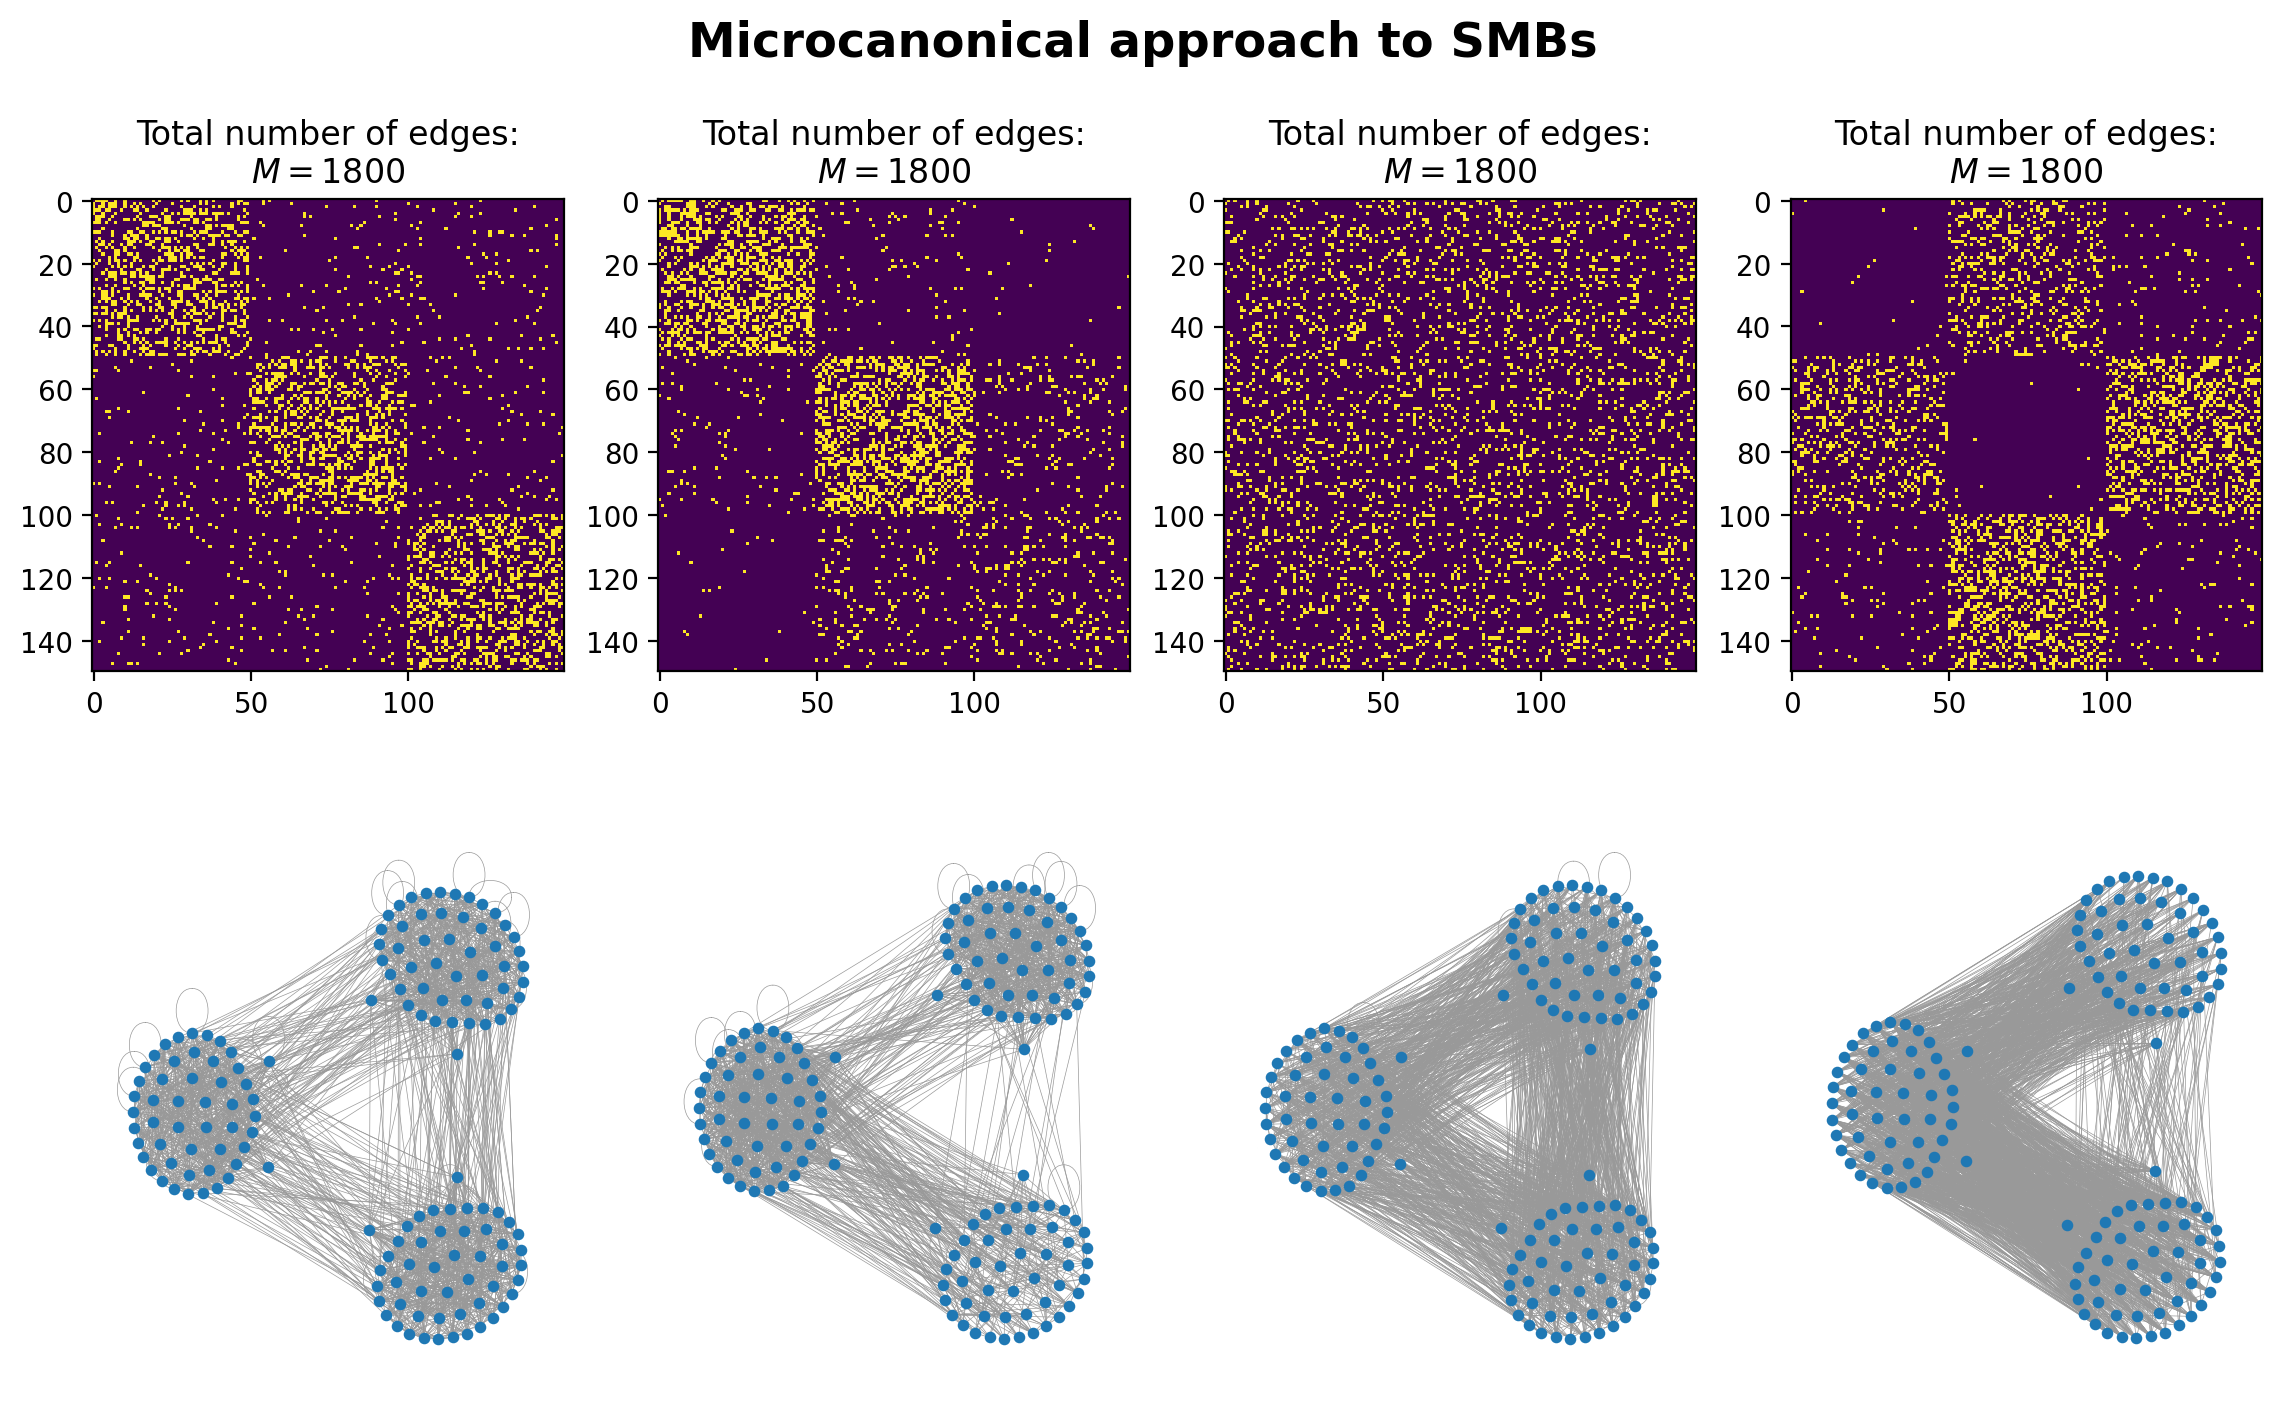

In [19]:
# instead of a matrix of probabilities, we have a matrix of edge counts between blocks
e1 = np.array([[500, 50, 50], 
               [50, 500, 50], 
               [50, 50, 500]])

e2 = np.array([[650, 50, 10], 
               [50, 700, 100], 
               [10, 100, 130]])

e3 = np.array([[200, 200, 200], 
               [200, 200, 200], 
               [200, 200, 200]])

e4 = np.array([[10, 600, 50], 
               [10, 10, 620], 
               [50, 400, 50]])

plot_blocks = [e1,e2,e3,e4]

fig, ax = plt.subplots(2,4,figsize=(14,8),dpi=200)

for x, block_matrix_x in enumerate(plot_blocks):

    Gx = create_graph_from_e(N, block_matrix_x)
    Aij = nx.to_numpy_array(Gx)

    ax[(0,x)].imshow(Aij, vmin=0, vmax=1)
    ax[(0,x)].set_title('Total number of edges:\n'+r"$M = %i$"%(Gx.number_of_edges()))

    nx.draw(Gx, pos=pos, node_size=10, width=0.25, edge_color='.6', ax=ax[(1,x)])

plt.suptitle('Microcanonical approach to SMBs', y=0.965, fontweight='bold', fontsize='xx-large')

plt.show()

## Preview --- Enter: `graph-tool`

Note: The remainder of this lesson will draw heavily from the [`graph-tool` documentation](https://graph-tool.skewed.de/) directly. This package is written and maintained almost entirely by [Tiago Peixoto](https://skewed.de/lab/contact.html), professor of Complex Systems and Network Science at IT:U in Linz, Austria.


https://graph-tool.skewed.de/static/doc/quickstart.html

**Punchline:** Use this package to detect communities (and other types of mesoscopic structures!!) in your network data.

![](images/graphtool.png)

__________
## Next time...
More communities! `class_05_communities_graphtool.ipynb`
_______

## References and further resources:

1. Class Webpages
    - Jupyter Book: https://network-science-data-and-models.github.io/phys7332_fa25/README.html
    - Github: https://github.com/network-science-data-and-models/phys7332_fa25/
    - Syllabus and course details: https://brennanklein.com/phys7332-fall25
2. White, H.C., Boorman, S.A., & Breiger, R.L. (1976). Social structure from multiple networks. I. Blockmodels of roles and positions. American Journal of Sociology, 81(4), 730-780. https://www.jstor.org/stable/2777596
3. Fortunato, S. (2010). Community detection in graphs. *Physics Reports*, 486(3), 75-174. https://doi.org/10.1016/j.physrep.2009.11.002
4. Fortunato, S., & Hric, D. (2016). Community detection in networks: A user guide. *Physics Reports*, 659, 1-44. https://doi.org/10.1016/j.physrep.2016.09.002
5. Chakraborty, T., Dalmia, A., Mukherjee, A., & Ganguly, N. (2017). Metrics for community analysis: A survey. *ACM Computing Surveys (CSUR)*, 50(4), 1-37. https://dl.acm.org/doi/10.1145/3091106
6. Good, B. H., De Montjoye, Y. A., & Clauset, A. (2010). Performance of modularity maximization in practical contexts. *Physical Review E*, 81(4), 046106. https://link.aps.org/doi/10.1103/PhysRevE.81.046106
7. Girvan M. & Newman M.E.J. (2002). Community structure in social and biological networks. Proceedings of the National Academy of Sciences, 99, 7821–7826. https://doi.org/10.1073/pnas.122653799
8. Newman, M.E.J., & Girvan, M. (2004). "Finding and evaluating community structure in networks." *Physical Review E*, 69(2), 026113. https://doi.org/10.1103/PhysRevE.69.026113
9. Rosvall, M. & Bergstrom, C.T. (2008). Maps of random walks on complex networks reveal community structure. *Proceedings of the National Academy of Sciences*, 105(4), 1118-1123. https://doi.org/10.1073/pnas.0706851105
10. Blondel, V. D., Guillaume, J. L., Lambiotte, R., & Lefebvre, E. (2008). Fast unfolding of communities in large networks. Journal of Statistical Mechanics, 2008(10), P10008. https://doi.org/10.1088/1742-5468/2008/10/P10008
11. Holland, P.W., Laskey, K.B., & Leinhardt, S. (1983). Stochastic blockmodels: First steps. *Social Networks*. 5(2), 109–137. https://doi.org/10.1016/0378-8733(83)90021-7
12. Ghasemian, A., Hosseinmardi, H., & Clauset, A. (2019). Evaluating overfit and underfit in models of network community structure. *IEEE Transactions on Knowledge and Data Engineering*, 32(9), 1722-1735. https://doi.org/10.1109/TKDE.2019.2911585
13. Guimera, R., Sales-Pardo, M., & Amaral, L.A.N. (2004). [Modularity from fluctuations in random graphs and complex networks](https://link.aps.org/doi/10.1103/PhysRevE.70.025101). *Physical Review E*, 70(2), 025101.

_________

## Appendix: Spectral Methods

### A more interpretable form of modularity (and why spectral methods work)

The "big sum over all pairs" definition is correct, but it hides intuition.

Define:

- $e_{rs}$ = fraction of total edge weight that runs between communities $r$ and $s$  
  (for unweighted graphs, "edge weight" = number of edges)

- $a_r = \sum_s e_{rs}$ = fraction of all *stubs* (edge-ends) attached to community $r$

Then you can show (Newman 2006) that modularity can be written as:

$$
Q = \sum_{r=1}^B \left(e_{rr} - a_r^2\right)
$$

Interpretation:

- $e_{rr}$ = **observed** within-community edge fraction
- $a_r^2$ = **expected** within-community edge fraction if stubs were randomly paired (configuration model)

So modularity is literally "within-edge fraction above chance," summed over groups.

---


**Why spectral modularity has a clean objective (2-way split):**

For a *bipartition*, encode group membership as $s_i \in \{+1,-1\}$ and note that

$$
\delta(z_i,z_j) = \frac{1 + s_i s_j}{2}.
$$

Plugging this into modularity gives:

$$
Q = \frac{1}{4m}\, \mathbf{s}^\top \mathbf{B}\, \mathbf{s},
$$

where $\mathbf{B}$ is the **modularity matrix** with entries $B_{ij}=A_{ij} - \frac{k_i k_j}{2m}$.

This is why the leading eigenvector of $\mathbf{B}$ is useful: it approximates the best sign-vector $\mathbf{s}$.


In [27]:
def edge_fraction_matrix(G, comms, weight=None):
    """Compute the community-to-community edge fraction matrix e_{rs}.

    For an undirected graph, define m as the total edge weight:
      m = \sum_{(u,v)\in E} w_{uv}
    so that 2m = \sum_i k_i.

    Then
      e_{rs} = (1/(2m)) \sum_{ij} A_{ij} 1[z_i=r] 1[z_j=s].

    Implementation detail:
    - Because the sum over (i,j) counts each undirected edge twice,
      we add each edge's weight to both (r,s) and (s,r).

    Parameters
    ----------
    G : nx.Graph
        Undirected graph.
    comms : list[set]
        Communities as node sets (assumed to be a partition here).
    weight : str or None
        Edge attribute name to treat as weights. If None, all edges have weight 1.

    Returns
    -------
    e : np.ndarray
        (B,B) array where B = #communities, and e.sum() == 1 (up to floating error).
    """
    labels = communities_to_labels(comms)
    B = len(comms)

    # total edge weight m
    if weight is None:
        m = float(G.number_of_edges())
        def w(u, v): return 1.0
    else:
        m = float(sum(G[u][v].get(weight, 1.0) for u, v in G.edges()))
        def w(u, v): return float(G[u][v].get(weight, 1.0))

    if m == 0:
        return np.zeros((B, B), dtype=float)

    e = np.zeros((B, B), dtype=float)
    two_m = 2.0 * m

    for u, v in G.edges():
        ru = labels[u]
        rv = labels[v]
        ww = w(u, v)
        e[ru, rv] += ww / two_m
        e[rv, ru] += ww / two_m  # symmetric contribution

    return e


def modularity_from_edge_fractions(e):
    """Compute modularity from an e_{rs} matrix via Q = sum_r (e_rr - a_r^2)."""
    a = e.sum(axis=1)
    return float(np.trace(e) - np.sum(a**2))


Q via edge-fraction formula: 0.482456
Q via networkx modularity:  0.482456
Sanity check (difference):  0.0
e matrix (rows/cols are communities):
[[0.491 0.009]
 [0.009 0.491]]


In [28]:

# Demo on the toy "two cliques + bridge" graph
e = edge_fraction_matrix(G_toy, true_comms)
Q_e = modularity_from_edge_fractions(e)
Q_nx = safe_modularity(G_toy, true_comms)

print("Q via edge-fraction formula:", round(Q_e, 6))
print("Q via networkx modularity: ", round(Q_nx, 6))
print("Sanity check (difference): ", abs(Q_e - Q_nx))
print("e matrix (rows/cols are communities):")
print(np.round(e, 3))

Q via edge-fraction formula: 0.482456
Q via networkx modularity:  0.482456
Sanity check (difference):  0.0
e matrix (rows/cols are communities):
[[0.491 0.009]
 [0.009 0.491]]


## Appendix: Spectral community detection

For a *two-way* split, you can write modularity as:

$$
Q = \frac{1}{4m}\, \mathbf{s}^\top \mathbf{B}\, \mathbf{s}
$$

where:
- $\mathbf{s} \in \{-1,+1\}^n$ indicates which side each node is on
- $\mathbf{B}$ is the **modularity matrix** with $B_{ij} = A_{ij} - \frac{k_i k_j}{2m}$

A common heuristic:
- take the leading eigenvector of $\mathbf{B}$
- split by its sign

This is useful conceptually because it connects community detection to the broader "spectral methods" toolbox.


In [42]:
def spectral_modularity_bipartition(G, weight=None, resolution=1.0):
    """
    Approximate modularity maximization via the modularity matrix (2-way split).

    This follows Newman's spectral heuristic:

    1. Build the modularity matrix
         B_ij = A_ij - γ (k_i k_j)/(2m)
       where k_i is (weighted) degree and m is total (weighted) edge count.

    2. Take the leading eigenvector of B.
    3. Split nodes by the sign of the eigenvector entries.

    This produces a *bipartition* only. (To get more than 2 communities you
    typically recurse on subgraphs or use a multiway method like Louvain.)

    Pedagogical note:
    - For γ=1, B has row/column sums ≈ 0, and the clean quadratic-form
      expression Q = (1/(4m)) s^T B s applies.
    - For γ≠1, there is an additive constant, but the same eigenvector heuristic
      is still a useful approximation.

    Parameters
    ----------
    G : nx.Graph
        Undirected graph.
    weight : str or None
        Edge attribute to use as weight. If None, treats graph as unweighted.
    resolution : float
        Resolution parameter γ.

    Returns
    -------
    comms : list[set]
        Two communities as node sets (or one community if no beneficial split).
    Q : float
        Modularity (at the same resolution γ) of the returned partition.
    """
    nodes = list(G.nodes())
    n = len(nodes)
    if n == 0:
        return [], 0.0

    # adjacency matrix (optionally weighted)
    A = nx.to_numpy_array(G, nodelist=nodes, weight=weight)
    k = A.sum(axis=1)              # (weighted) degrees
    m = float(k.sum() / 2.0)       # total (weighted) edge weight

    if m == 0:
        return [set(nodes)], 0.0

    # Modularity matrix
    B = A - resolution * np.outer(k, k) / (2.0 * m)

    # B is symmetric for undirected graphs → use eigh
    evals, evecs = np.linalg.eigh(B)
    leading_ix = int(np.argmax(evals))
    leading_vec = evecs[:, leading_ix]

    # Split by sign (ties go to +1)
    s = np.where(leading_vec >= 0, 1, -1)
    comm1 = {nodes[i] for i in range(n) if s[i] == 1}
    comm2 = set(nodes) - comm1

    # Candidate partition(s)
    if len(comm1) == 0 or len(comm2) == 0:
        comms_split = [set(nodes)]
    else:
        comms_split = [comm1, comm2]

    # Keep the better of: split vs no-split (according to the same γ)
    Q_split = safe_modularity(G, comms_split, weight=weight, resolution=resolution)
    Q_one = safe_modularity(G, [set(nodes)], weight=weight, resolution=resolution)

    if Q_split <= Q_one + 1e-12:
        return [set(nodes)], Q_one
    return comms_split, Q_split

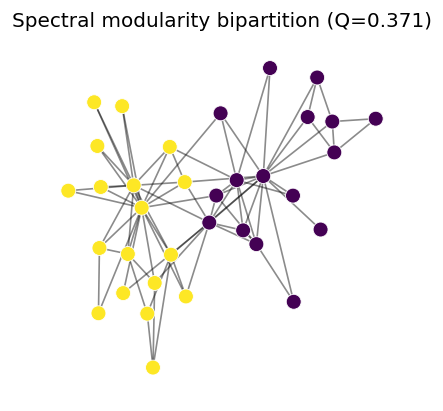

In [43]:
G = nx.karate_club_graph()
posK = nx.spring_layout(G, seed=4)

spec_comms, Q_spec = spectral_modularity_bipartition(G)

ax, _ = draw_partition(G, spec_comms, pos=posK, title=f"Spectral modularity bipartition (Q={Q_spec:.3f})")
plt.show()


### Appendix: Label propagation (Raghavan–Albert–Kumara)

A very different **community detection** idea: start with each node in its own community, then repeatedly let each node adopt the **most common label among its neighbors**.

This is pedagogically useful because it makes the assumptions *painfully explicit*:

- communities emerge from **local majority pressure** (no global objective is directly optimized)
- the result can depend on the **update order** and **tie-breaking**
- it converges quickly in practice, but may have multiple fixed points

**Asynchronous label propagation (one common variant)**

1. Initialize labels: $\ell_i \leftarrow i$
2. Repeat until convergence:
   - visit nodes in random order
   - set $\ell_i \leftarrow \arg\max_{\ell} \#\{j \in N(i): \ell_j = \ell\}$
   - break ties randomly

We'll implement it from scratch so you can see every moving part.


In [44]:
from collections import Counter

def label_propagation(G: nx.Graph, max_iter: int = 100, seed: int = 0, verbose: bool = False):
    """Asynchronous label propagation from scratch.

    Returns
    -------
    comms : list[set]
        Communities as node-sets (a *partition* of the nodes).
    labels : dict
        Node -> label at convergence (labels are arbitrary integers).
    """
    rng = np.random.default_rng(seed)
    nodes = list(G.nodes())

    # Start with a unique label per node
    labels = {v: i for i, v in enumerate(nodes)}

    for it in range(max_iter):
        changed = False
        rng.shuffle(nodes)

        for v in nodes:
            nbrs = list(G.neighbors(v))
            if len(nbrs) == 0:
                continue

            # Count neighbor labels
            counts = Counter(labels[u] for u in nbrs)
            best_count = max(counts.values())
            best_labels = [lab for lab, c in counts.items() if c == best_count]

            # Tie-breaking matters!
            new_lab = int(rng.choice(best_labels))

            if labels[v] != new_lab:
                labels[v] = new_lab
                changed = True

        if verbose:
            print(f"iter={it:02d} changed={changed}")

        if not changed:
            break

    # Convert labels -> list of communities
    comms_dict = {}
    for v, lab in labels.items():
        comms_dict.setdefault(lab, set()).add(v)

    comms = list(comms_dict.values())
    return comms, labels


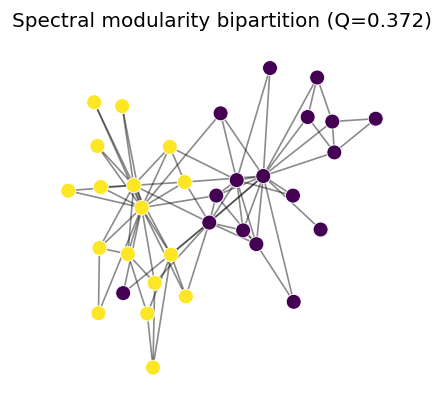

In [57]:
G = nx.karate_club_graph()

comms_lp, _ = label_propagation(G, max_iter=1000)
# comms_lp, _ = label_propagation(G, max_iter=100)
# comms_lp, _ = label_propagation(G, max_iter=10)
Q_lp = safe_modularity(G, comms_lp)

posK = nx.spring_layout(G, seed=4)

ax, _ = draw_partition(G, comms_lp, pos=posK, title=f"Spectral modularity bipartition (Q={Q_lp:.3f})")
plt.show()


### Appendix: Clique percolation (k-clique communities, overlapping)

Most algorithms we’ve used so far output a **partition**: every node belongs to exactly one community.

But sometimes communities overlap (e.g., you can be in multiple social circles).

The **k-clique percolation** idea (Palla et al.):

1. Find all **k-cliques** (complete subgraphs of size $k$).
2. Build a graph whose nodes are those k-cliques.
3. Connect two k-cliques if they share **$k-1$ nodes**.
4. Each connected component of this "clique graph" is a community (take the union of nodes).

This gives **overlapping** communities: a node can appear in multiple components.

We'll implement it step-by-step.

In [58]:
import itertools

def k_clique_percolation(G: nx.Graph, k: int):
    """k-clique percolation communities (overlapping) from scratch.

    Returns
    -------
    comms : list[set]
        Each community is a set of nodes (nodes may appear in multiple comms).
    kcliques : list[frozenset]
        The list of all k-cliques found.
    clique_graph : nx.Graph
        Graph on cliques: cliques adjacent if they share k-1 nodes.
    """
    if k < 2:
        raise ValueError("k must be >= 2")

    # 1) Find all k-cliques.
    # networkx.find_cliques gives maximal cliques; we expand them into k-subcliques.
    kcliques_set = set()
    for max_clique in nx.find_cliques(G):
        if len(max_clique) >= k:
            for comb in itertools.combinations(max_clique, k):
                kcliques_set.add(frozenset(comb))

    kcliques = sorted(kcliques_set, key=lambda c: tuple(sorted(c)))
    if len(kcliques) == 0:
        return [], [], nx.Graph()

    # 2) Build the clique adjacency graph
    C = nx.Graph()
    C.add_nodes_from(range(len(kcliques)))

    # 3) Link cliques that share k-1 nodes
    for i, j in itertools.combinations(range(len(kcliques)), 2):
        if len(kcliques[i].intersection(kcliques[j])) >= k - 1:
            C.add_edge(i, j)

    # 4) Communities = connected components in clique graph, expanded back to node sets
    comms = []
    for comp in nx.connected_components(C):
        nodes = set()
        for idx in comp:
            nodes |= set(kcliques[idx])
        comms.append(nodes)

    return comms, kcliques, C


# A tiny overlapping example
G_overlap = nx.Graph()
G_overlap.add_edges_from([
    (0,1),(1,2),(0,2),   # triangle 0-1-2
    (2,3),(3,4),(2,4),   # triangle 2-3-4  (shares node 2)
])

comms3, cliques3, C3 = k_clique_percolation(G_overlap, k=3)

print("k=3 cliques:", cliques3)
print("k=3 communities (overlapping possible):", comms3)
print("node 2 appears in how many comms?", sum(2 in c for c in comms3))

k=3 cliques: [frozenset({0, 1, 2}), frozenset({2, 3, 4})]
k=3 communities (overlapping possible): [{0, 1, 2}, {2, 3, 4}]
node 2 appears in how many comms? 2


## Appendix: Bipartite graphs --- projection is convenient, but it changes the question



In a bipartite network there are *two node types* and edges only go across types.
If you run "standard" modularity maximization on the raw bipartite graph, a common outcome is:

- one community = most/all of the top nodes
- another community = most/all of the bottom nodes

...which is rarely what you mean by "community."

A common workaround is a **one-mode projection** (e.g., project people–events onto people).
But projection creates edges between nodes that share neighbors, which can:

- create artificial cliques,
- inflate density,
- and blur distinct mechanisms.

## Other common algorithms

### 1. Spectral Optimization

Based on a modularity matrix:

$$ B_{i,j} = A_{i,j} - \frac{k_ik_j}{2M} $$

Then,

\begin{eqnarray}
Q &=& \frac{1}{2M} \sum_{i,j} \left( A_{i,j} - \frac{k_ik_j}{2M} \right) \delta(C_i,C_j) \\
 &=& \frac{1}{4M} \sum_{i,j} \left( A_{i,j} - \frac{k_ik_j}{2M} \right) (s_is_j + 1)  \\
 &=& \frac{1}{4M} \sum_{i,j} B_{i,j}s_is_j   \\ 
 &=& \frac{1}{4M} s^TBs 
\end{eqnarray}

Notice that:
1. $ \dfrac{s_is_j + 1}{2} $ is equal to 1 if $i$ and $j$ belong to the same community, 0 otherwise.
2. $ \sum_{i,j}A_{i,j} = \sum_{i}k_{i} = 2M $. 

Matrix $B$ is ___symmetric___ and it has $N$ orthonormal eigenvectors. Then, it can be shown that the previous equation can be rewritten as:

$$ Q = \frac{1}{4M} \sum_{i} \left( u_i^Ts \right)^2\lambda_i ,$$

where $u_i$ is an eigenvector of $B$ associated to the eigenvalue $\lambda_i$.

Therefore, the modularity maximization consists in setting the values of $s$ as to maximize the contribution of the leading eigenvalue (i.e. $\lambda_1$) of $B$.

Under the constraint that the entries of $s$ have to be either $+1$ or $-1$, we can find the optimal graph partitioning by setting $s_i = 1$ if $u_i > 0$; $s_i = -1$, otherwise.

### 2. Infomap

This is an ***information theoretic approach*** that reveals community structure in weighted and directed networks. The main idea is to find the best compressed description of the path of a random walker traversing the graph. 

In practice, we want to minimize the ***map equation***:

$$ L(M) = q_{between}H(\mathbb{L}) + \sum_{i=1}^m p_{within}^iH(\mathbb{P}^i) ,$$

where $q_{between}$ is the probability that the random walker moves in a different module at each step, $p_{within}^i$ is the probability that the random walker next step will be within the same module $i$, $H(x)$ denotes the *entropy* of the codewords used to describe $x$ using *Huffman coding* (https://en.wikipedia.org/wiki/Huffman_coding).

![](images/infomap.png)

[1] Rosvall, M., & Bergstrom, C.T. (2008). Maps of random walks on complex networks reveal community structure. Proceedings of the National Academy of Sciences, 105(4), 1118-1123. https://doi.org/10.1073/pnas.0706851105

### 3. Your turn! 
In the remaining time, it's your chance to do a short mini-lit review. Find a community detection algorithm by searching google scholar. See if you can quickly skim through any descriptions you find on it to answer the following:
- What measure is being optimized (i.e., how do we know a given partition is optimal---or even good---under this approach?)
- Algorithmically, how are partitions selected/sampled?
- When did this technique come out? How many citations does it have?
